### Read dataset, import 

In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.stats import skew, kurtosis, norm, expon, gamma
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import Point, Polygon


from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# Use a sans-serif font
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DeJavu Serif']

In [12]:
florida_df = pd.read_csv("dataset/geocoded.csv")
florida_df.drop(['Unnamed: 0'], axis=1, inplace=True)
# Reproject and make it gdf
geometry = [Point(lon, lat) for lon, lat in zip(florida_df['longitude'], florida_df['latitude'])]
gdf = gpd.GeoDataFrame(florida_df, geometry=geometry, crs='EPSG:4326')
proj_crs = 'EPSG:3086'
gdf = gdf.to_crs(proj_crs)
grouped = gdf.groupby("source")


# SDE

C:\Users\vrace\AppData\Local\Temp\ipykernel_23404\3517584520.py:76: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower left', fontsize=9)


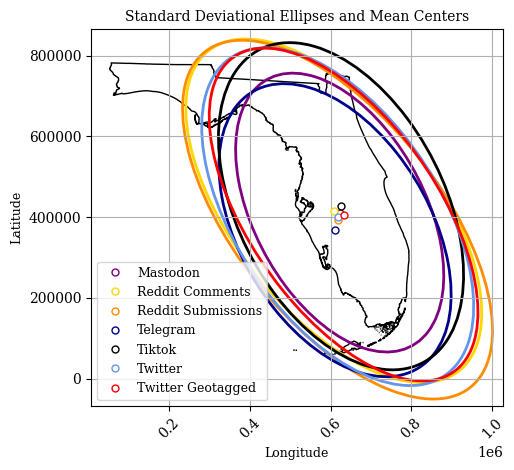

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import pandas as pd
import geopandas as gpd

# Load Florida state border
gpkg_file = "dataset/florida_boundary.gpkg"
gdf_state = gpd.read_file(gpkg_file, layer='border')

def plot_standard_deviational_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0,  0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig, ax = plt.subplots()

# Plot Florida state border
gdf_state.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='Florida Border')

grouped = gdf.groupby('source')

# Define colors for different groups
color_map = {
    'Twitter': 'cornflowerblue',
    'Tiktok': 'black',
    'Reddit Submissions': 'darkorange',
    'Reddit Comments': 'gold',
    'Telegram': 'darkblue',
    'Mastodon': 'purple',
    'Twitter Geotagged': 'red'
}

# Plot standard deviational ellipses and mean centers for each group
for group, data in grouped:
    x_data = data.geometry.x
    y_data = data.geometry.y
    color = color_map[group] if group in color_map else 'black'  # Use black if color not defined
    plot_standard_deviational_ellipse(x_data, y_data, ax, n_std=3, edgecolor=color, linewidth=2)
    
    # Compute mean center coordinates
    mean_x = np.mean(x_data)
    mean_y = np.mean(y_data)
    
    # Plot mean center as marker
    ax.plot(mean_x, mean_y, marker='o', markersize=5, color='white', markeredgecolor=color, label=group)

ax.set_xlabel('Longitude',fontsize=9)
ax.set_ylabel('Latitude', fontsize=9)
ax.set_title('Standard Deviational Ellipses and Mean Centers', fontsize=10) #, fontweight='bold')


# Move legend inside the plot
ax.legend(loc='lower left', fontsize=9)


# Rotate x-axis labels
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# Define functions for ellipse metrics calculation
def calculate_ellipse_area(width, height):
    return np.pi * width * height / 4

def calculate_aspect_ratio(width, height):
    return width / height

def calculate_orientation(angle_deg):
    return angle_deg

# Initialize lists to store calculated metrics
groups = []
areas = []
aspect_ratios = []
orientations = []

for group, data in grouped:
    cov = np.cov(data.geometry.x, data.geometry.y)
    pearson = cov[0, 1] / np.sqrt(cov[0,  0] * cov[1, 1])
    
    # Calculate ellipse parameters for three standard deviations
    ellipse_angle_deg = np.degrees(np.arctan2(2 * pearson * np.sqrt(cov[0, 0] * cov[1, 1]), (cov[0, 0] - cov[1, 1]))) / 2.0
    ellipse_width = np.sqrt(1 + pearson) * 2 * np.sqrt(cov[0, 0]) * 3  # three standard deviations
    ellipse_height = np.sqrt(1 - pearson) * 2 * np.sqrt(cov[1, 1]) * 3  # three standard deviations or two?
    
    area = calculate_ellipse_area(ellipse_width, ellipse_height)
    aspect_ratio = calculate_aspect_ratio(ellipse_width, ellipse_height)
    orientation = calculate_orientation(ellipse_angle_deg)
    area = area/1000000
    
    # Append calculated metrics to lists
    groups.append(group)
    areas.append(area)
    aspect_ratios.append(aspect_ratio)
    orientations.append(orientation)

df_metrics = pd.DataFrame({
    'Group': groups,
    'Area': areas,
    'Aspect Ratio': aspect_ratios,
    'Orientation (degrees)': orientations
})

# Convert DataFrame to LaTeX table
latex_table = df_metrics.to_latex(index=False)
print(latex_table)


\begin{tabular}{lrrr}
\toprule
Group & Area & Aspect Ratio & Orientation (degrees) \\
\midrule
Mastodon & 249406.333985 & 0.458798 & -61.650673 \\
Reddit Comments & 393562.299708 & 0.434060 & -52.063441 \\
Reddit Submissions & 421369.594431 & 0.420075 & -51.688198 \\
Telegram & 294426.457752 & 0.494480 & -59.052969 \\
Tiktok & 350515.692346 & 0.478544 & -62.431336 \\
Twitter & 374866.304271 & 0.445559 & -56.170365 \\
Twitter Geotagged & 348587.647810 & 0.411596 & -55.067537 \\
\bottomrule
\end{tabular}



## correlation matrix

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\scipy\integrate\_quadpack_py.py:1225: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


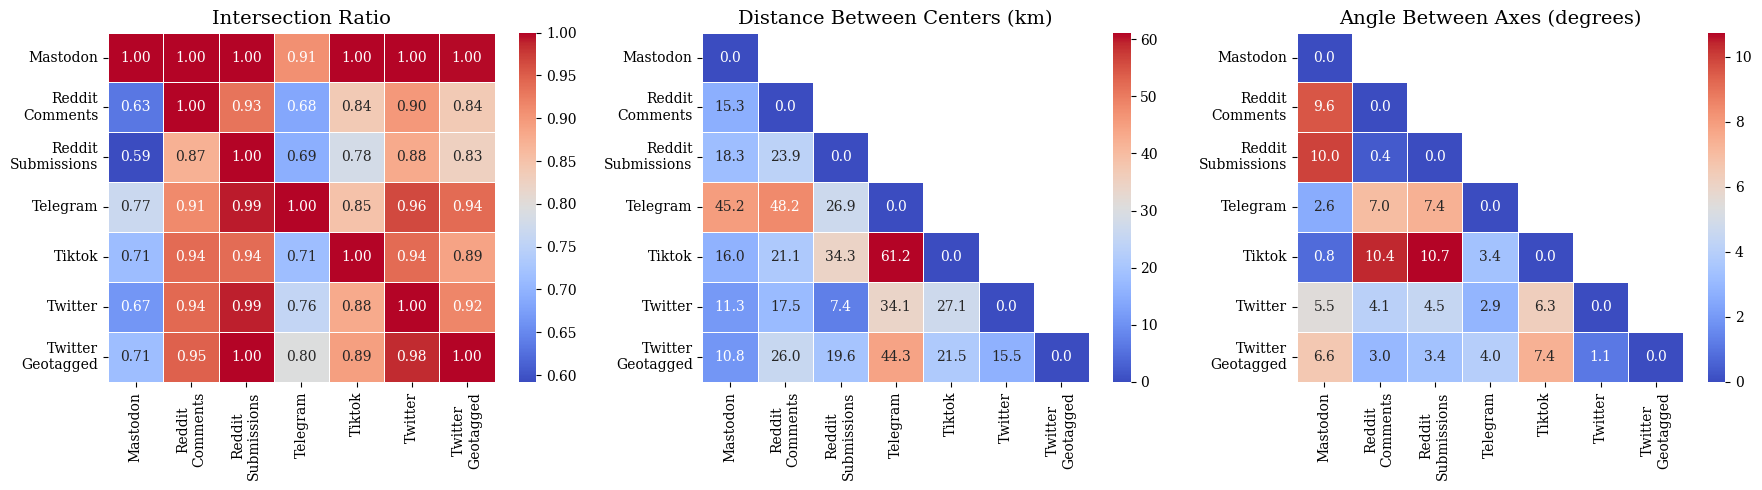

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.integrate import dblquad
from shapely import affinity

def ellipse_function(x, y, a, b):
    return (x**2 / a**2) + (y**2 / b**2)

def intersection_area_of_ellipses(ellipse1_params, ellipse2_params):
    a1, b1, x1, y1, theta1 = ellipse1_params
    a2, b2, x2, y2, theta2 = ellipse2_params
    
    def integrand(x, y):
        return np.minimum(ellipse_function(x, y, a1, b1), ellipse_function(x, y, a2, b2))
    
    # Define bounds for integration based on the larger ellipse
    bounds_x = (-a1, a1)
    bounds_y = (-b1, b1)
    
    # Integrate the minimum function over the ellipse
    intersection_area, _ = dblquad(integrand, *bounds_y, lambda y: -np.sqrt(a1**2 - (a1**2 / b1**2) * y**2), lambda y: np.sqrt(a1**2 - (a1**2 / b1**2) * y**2))
    
    return intersection_area

def calculate_overlap_index(area1, area2, intersection_area):
    return intersection_area / min(area1, area2)

def calculate_distance_between_centers(center1, center2):
    return np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)

def calculate_angle_between_axes(angle1_deg, angle2_deg):
    return np.abs(angle1_deg - angle2_deg)

from shapely import affinity

def calculate_ellipse_area(width, height):
    return np.pi * width * height

def calculate_aspect_ratio(width, height):
    return width / height

def calculate_orientation(ellipse_angle_deg):
    return ellipse_angle_deg % 180  # Angle between 0 and 180 degrees

def create_ellipse(center, lengths, angle=0):
    """
    create a shapely ellipse. adapted from
    https://gis.stackexchange.com/a/243462
    """
    circ = Point(center).buffer(1)
    ell = affinity.scale(circ, int(lengths[0]), int(lengths[1]))
    ellr = affinity.rotate(ell, angle)
    return ellr


grouped = gdf.groupby('source')


# Initialize lists to store calculated metrics
comparison_data = []

# Calculate metrics for each group
for group1, data1 in grouped:
    cov1 = np.cov(data1.geometry.x, data1.geometry.y)
    pearson1 = cov1[0, 1] / np.sqrt(cov1[0,  0] * cov1[1, 1])
    ellipse_angle_deg1 = np.degrees(np.arctan2(2 * pearson1 * np.sqrt(cov1[0, 0] * cov1[1, 1]), (cov1[0, 0] - cov1[1, 1]))) / 2.0
    ellipse_width1 = np.sqrt(1 + pearson1) * 2 * np.sqrt(cov1[0, 0])
    ellipse_height1 = np.sqrt(1 - pearson1) * 2 * np.sqrt(cov1[1, 1])
    center1 = (np.mean(data1.geometry.x), np.mean(data1.geometry.y))
    area1 = calculate_ellipse_area(ellipse_width1, ellipse_height1)
    mean_x = np.mean(data1.geometry.x)
    mean_y = np.mean(data1.geometry.y)
    orientation = calculate_orientation(ellipse_angle_deg1)

    
    ellipse1 = create_ellipse((mean_x, mean_y), (ellipse_width1, ellipse_height1), orientation)
    verts1 = np.array(ellipse1.exterior.coords.xy)
    patch = Polygon(verts1.T)


    ##compute areas and ratios 
    # print('area of ellipse 1:',ellipse1.area)
    
    for group2, data2 in grouped:
        if group1 == group2:
            continue
        
        cov2 = np.cov(data2.geometry.x, data2.geometry.y)
        pearson2 = cov2[0, 1] / np.sqrt(cov2[0,  0] * cov2[1, 1])
        ellipse_angle_deg2 = np.degrees(np.arctan2(2 * pearson2 * np.sqrt(cov2[0, 0] * cov2[1, 1]), (cov2[0, 0] - cov2[1, 1]))) / 2.0
        ellipse_width2 = np.sqrt(1 + pearson2) * 2 * np.sqrt(cov2[0, 0])
        ellipse_height2 = np.sqrt(1 - pearson2) * 2 * np.sqrt(cov2[1, 1])
        center2 = (np.mean(data2.geometry.x), np.mean(data2.geometry.y))
        area2 = calculate_ellipse_area(ellipse_width2, ellipse_height2)
        
        mean_x = np.mean(data2.geometry.x)
        mean_y = np.mean(data2.geometry.y)
        orientation = calculate_orientation(ellipse_angle_deg2)

        
        ellipse2 = create_ellipse((mean_x, mean_y), (ellipse_width2, ellipse_height2), orientation)

        # print(area2)
        
        # Calculate intersection area of the two ellipses
        ellipse1_params = (ellipse_width1 / 2, ellipse_height1 / 2, center1[0], center1[1], ellipse_angle_deg1)
        ellipse2_params = (ellipse_width2 / 2, ellipse_height2 / 2, center2[0], center2[1], ellipse_angle_deg2)
        intersection_area = intersection_area_of_ellipses(ellipse1_params, ellipse2_params)
        
        # Calculate overlap index
        overlap_index = calculate_overlap_index(area1, area2, intersection_area)
        
        # Calculate distance between centers
        distance_centers = calculate_distance_between_centers(center1, center2)
        distance_centers = distance_centers/1000
        
        # Calculate angle between axes
        angle_between_axes = calculate_angle_between_axes(ellipse_angle_deg1, ellipse_angle_deg2)
        
        intersect = ellipse1.intersection(ellipse2)

        
        overlap_index = intersect.area/ellipse1.area
        overlap_index = round(overlap_index, 3)
        # print(overlap_index)

        # Append comparison metrics to the list
        comparison_data.append([group1, group2, overlap_index, distance_centers, angle_between_axes])

# Convert list to DataFrame
df_comparison = pd.DataFrame(comparison_data, columns=['Group1', 'Group2', 'Overlap Index', 'Distance Between Centers', 'Angle Between Axes'])

# Iterate through Group1 and Group2 to replace spaces with '\n'
df_comparison['Group1'] = df_comparison['Group1'].str.replace(' ', '\n')
df_comparison['Group2'] = df_comparison['Group2'].str.replace(' ', '\n')
# Pivot the DataFrame to create correlation matrices for each metric
corr_matrix_overlap = df_comparison.pivot_table(index='Group1', columns='Group2', values='Overlap Index', fill_value=1)
corr_matrix_distance = df_comparison.pivot_table(index='Group1', columns='Group2', values='Distance Between Centers', fill_value=0)
corr_matrix_angle = df_comparison.pivot_table(index='Group1', columns='Group2', values='Angle Between Axes', fill_value=0)

mask = np.triu(np.ones_like(corr_matrix_distance, dtype=bool))
mask = np.triu(np.ones_like(corr_matrix_angle, dtype=bool))


# Plot correlation matrices as heatmaps

mask_distance = np.triu(np.ones_like(corr_matrix_distance, dtype=bool), k=1)  # Exclude the diagonal
mask_angle = np.triu(np.ones_like(corr_matrix_angle, dtype=bool), k=1)  

# Plot correlation matrices as heatmaps
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(corr_matrix_overlap, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Intersection Ratio', fontsize = 14)
plt.xlabel('')  # Remove x-label
plt.ylabel('')  # Remove y-label


plt.subplot(1, 3, 2)
sns.heatmap(corr_matrix_distance, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5, mask=mask_distance)
plt.title('Distance Between Centers (km)', fontsize = 14)
plt.xlabel('')  # Remove x-label
plt.ylabel('')  # Remove y-label

plt.subplot(1, 3, 3)
sns.heatmap(corr_matrix_angle, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5, mask=mask_angle)
plt.title('Angle Between Axes (degrees)', fontsize = 14)
plt.xlabel('')  # Remove x-label
plt.ylabel('')  # Remove y-label

plt.tight_layout()
plt.show()

<Figure size 1800x500 with 0 Axes>

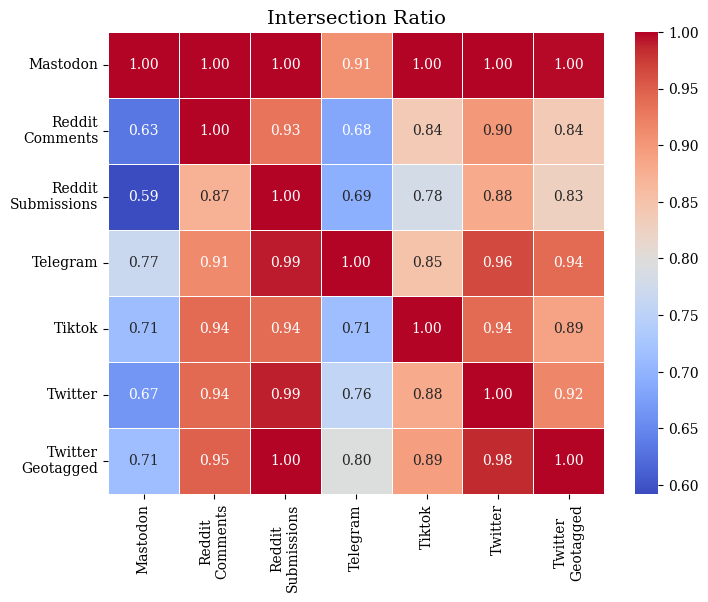

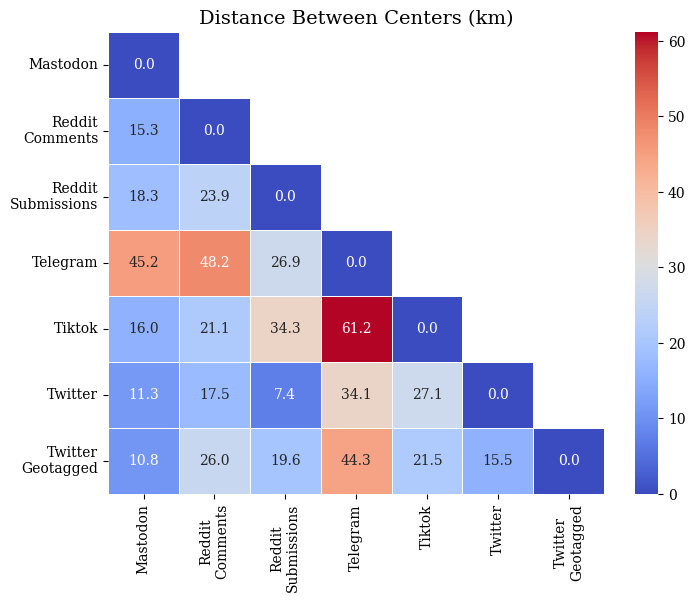

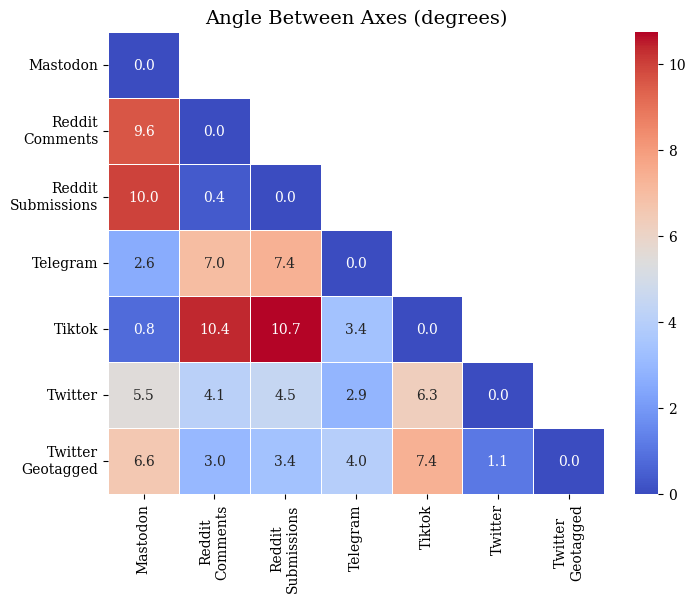

In [ ]:
# Convert list to DataFrame
df_comparison = pd.DataFrame(comparison_data, columns=['Group1', 'Group2', 'Overlap Index', 'Distance Between Centers', 'Angle Between Axes'])

# Replace spaces with '\n' for better visualization
df_comparison['Group1'] = df_comparison['Group1'].str.replace(' ', '\n')
df_comparison['Group2'] = df_comparison['Group2'].str.replace(' ', '\n')

# Pivot the DataFrame to create correlation matrices for each metric
corr_matrix_overlap = df_comparison.pivot_table(index='Group1', columns='Group2', values='Overlap Index', fill_value=1)
corr_matrix_distance = df_comparison.pivot_table(index='Group1', columns='Group2', values='Distance Between Centers', fill_value=0)
corr_matrix_angle = df_comparison.pivot_table(index='Group1', columns='Group2', values='Angle Between Axes', fill_value=0)

# Create masks for the heatmaps
mask_distance = np.triu(np.ones_like(corr_matrix_distance, dtype=bool), k=1)
mask_angle = np.triu(np.ones_like(corr_matrix_angle, dtype=bool), k=1)

# Plot each correlation matrix as a separate heatmap
plt.figure(figsize=(18, 5))

# Intersection Ratio Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_overlap, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Intersection Ratio', fontsize=14)
plt.xlabel('')  # Remove x-label
plt.ylabel('')  # Remove y-label
plt.show()

# Distance Between Centers Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_distance, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5, mask=mask_distance)
plt.title('Distance Between Centers (km)', fontsize=14)
plt.xlabel('')  # Remove x-label
plt.ylabel('')  # Remove y-label
plt.show()

# Angle Between Axes Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_angle, annot=True, fmt=".1f", cmap='coolwarm', linewidths=.5, mask=mask_angle)
plt.title('Angle Between Axes (degrees)', fontsize=14)
plt.xlabel('')  # Remove x-label
plt.ylabel('')  # Remove y-label
plt.show()

# CDF of x and y

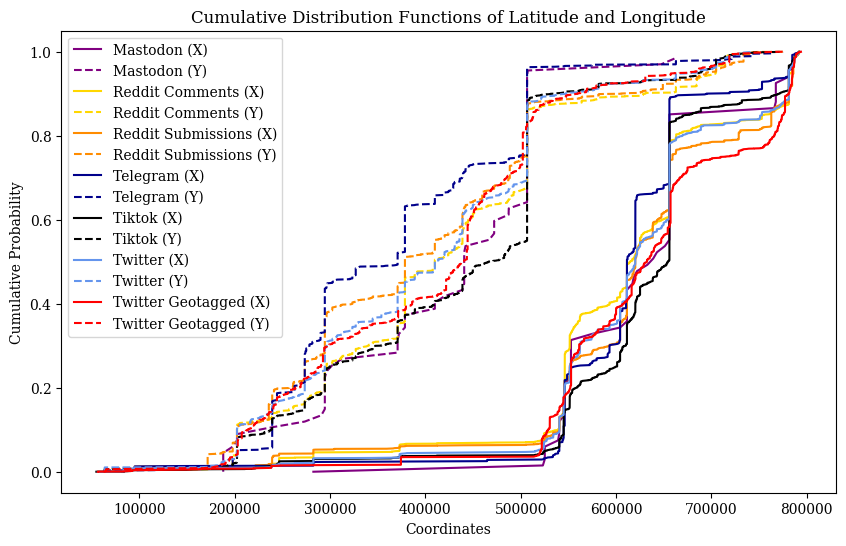

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns  # For KDE and CDF plots
import pandas as pd
import numpy as np


color_map = {
    'Twitter': 'cornflowerblue',
    'Tiktok': 'black',
    'Reddit Submissions': 'darkorange',
    'Reddit Comments': 'gold',
    'Telegram': 'darkblue',
    'Mastodon': 'purple',
    'Twitter Geotagged': 'red',

}
# Create a new figure
plt.figure(figsize=(10, 6))
# Iterate over each group and plot the CDFs for x and y coordinates
for i, (source, data) in enumerate(grouped):
    # Calculate CDF for x coordinates
    x_values = np.sort(data.geometry.x)
    x_cdf = np.arange(len(x_values)) / float(len(x_values))
    
    # Calculate CDF for y coordinates
    y_values = np.sort(data.geometry.y)
    y_cdf = np.arange(len(y_values)) / float(len(y_values))
    
    # Plot CDF for x coordinates 
    plt.plot(x_values, x_cdf, label=f'{source} (X)', color=color_map.get(source, 'gray'))
    
    # Plot CDF for y coordinates 
    plt.plot(y_values, y_cdf, label=f'{source} (Y)', linestyle='--', color=color_map.get(source, 'gray'))

# Add labels, title, and legend
plt.xlabel('Coordinates')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Functions of Latitude and Longitude')
plt.legend()

# Show plot
plt.show()


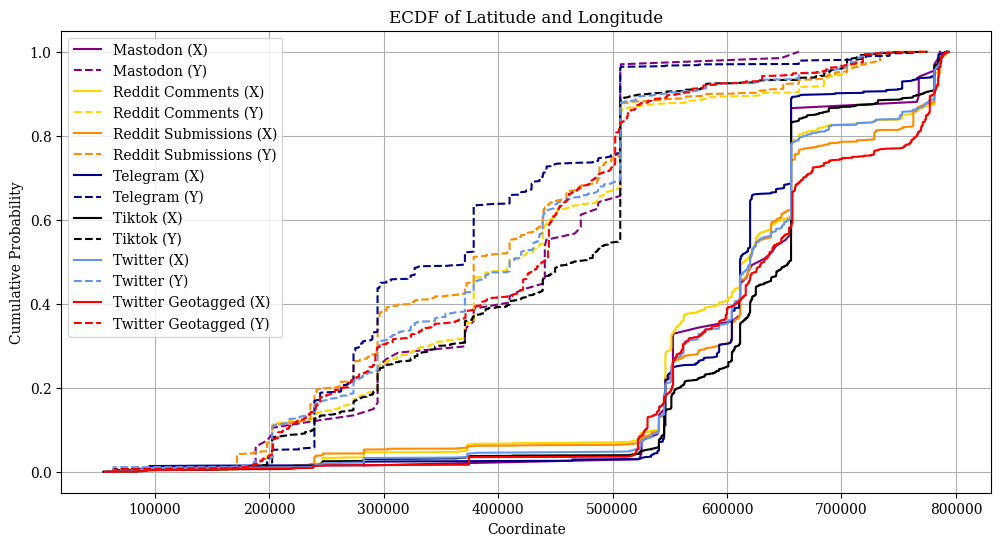

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

grouped = gdf.groupby('source')

plt.figure(figsize=(12, 6))

for source, data in grouped:
    # Extract the x and y coordinates of the points in the current group
    x = data.geometry.x.values
    y = data.geometry.y.values

    # Calculate ECDF for x and y coordinates
    ecdf_x = ECDF(x)
    ecdf_y = ECDF(y)
    
    color_map = {
        'Twitter': 'cornflowerblue',
        'Tiktok': 'black',
        'Reddit Submissions': 'darkorange',
        'Reddit Comments': 'gold',
        'Telegram': 'darkblue',
        'Mastodon': 'purple',
        'Twitter Geotagged': 'red',
    }
    
    # Plot CDF for x
    plt.plot(ecdf_x.x, ecdf_x.y, label=f'{source} (X)', color=color_map.get(source, 'gray'))
    
    # Plot CDF for y
    plt.plot(ecdf_y.x, ecdf_y.y, label=f'{source} (Y)', linestyle='--', color=color_map.get(source, 'gray'))

# Add labels, title, and legend
plt.xlabel('Coordinate')
plt.ylabel('Cumulative Probability')
plt.title('ECDF of Latitude and Longitude')
plt.legend()
plt.grid(True)
plt.show()

# Distribution

### Skewness, kurtosis and distribution

Mastodon Longitude Skewness: -0.4261071362052444, Kurtosis: 2.410162720869933
Mastodon Latitude Skewness: -0.44998850666865137, Kurtosis: -0.5588844683588894
Mastodon Longitude: Best Distribution: norm, Parameters: (622380.6555953678, 85260.22846867985)
Mastodon Latitude: Best Distribution: norm, Parameters: (411057.96641253115, 114224.90624022634)


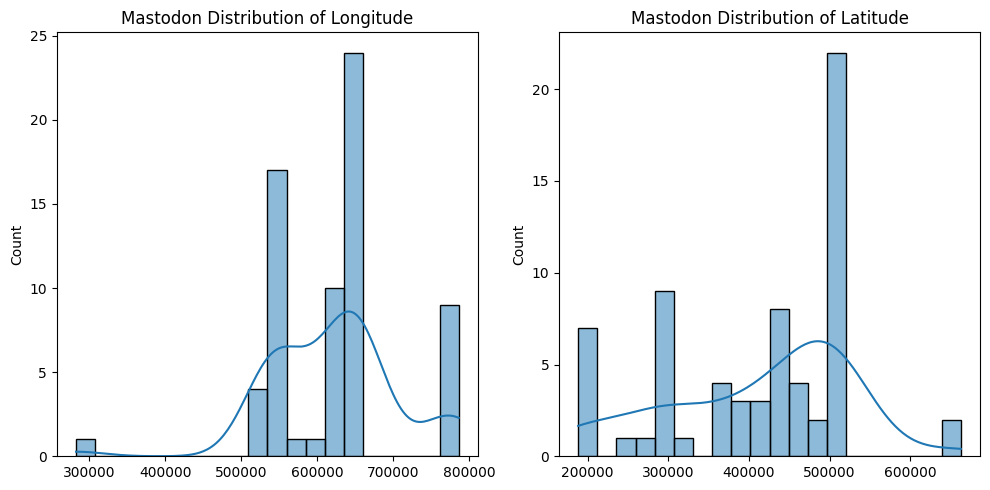

Reddit Comments Longitude Skewness: -1.2596734806309138, Kurtosis: 3.2415782192532587
Reddit Comments Latitude Skewness: 0.26806921022111607, Kurtosis: -0.3155584678742027
Reddit Comments Longitude: Best Distribution: norm, Parameters: (607789.6500981638, 122129.16558083214)
Reddit Comments Latitude: Best Distribution: gamma, Parameters: (28.646191527975255, -345772.5971206961, 26575.737329070726)


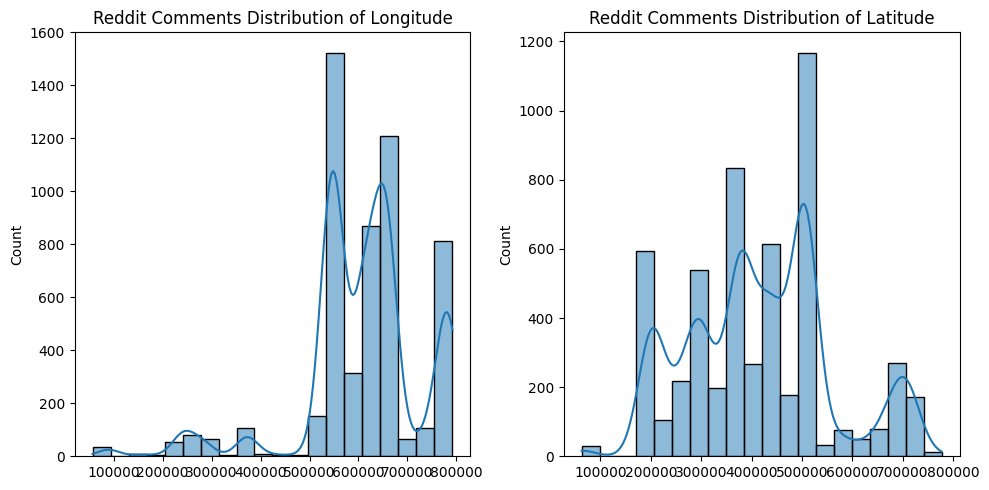

Reddit Submissions Longitude Skewness: -1.5831829507773176, Kurtosis: 4.140709397758486
Reddit Submissions Latitude Skewness: 0.4309162261818803, Kurtosis: -0.3824071364412842
Reddit Submissions Longitude: Best Distribution: norm, Parameters: (617050.194279841, 127914.77766540324)
Reddit Submissions Latitude: Best Distribution: gamma, Parameters: (9.552361483070246, -68465.25450802638, 48363.833058120064)


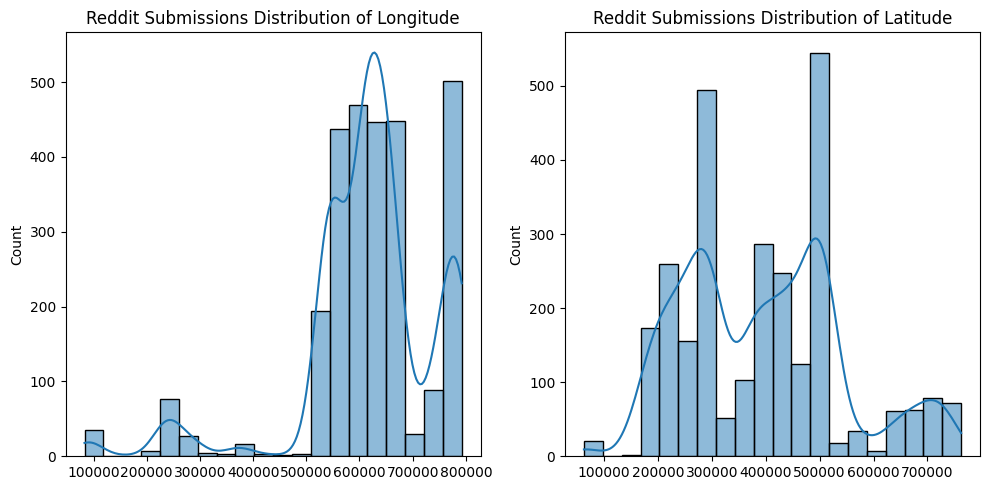

Tiktok Longitude Skewness: -1.9006140181248243, Kurtosis: 7.1594863303609255
Tiktok Latitude Skewness: -0.09875494894790575, Kurtosis: -0.33595149915203004
Tiktok Longitude: Best Distribution: norm, Parameters: (625500.2858154359, 101419.99113349564)
Tiktok Latitude: Best Distribution: norm, Parameters: (426253.0181612779, 135146.0852342133)


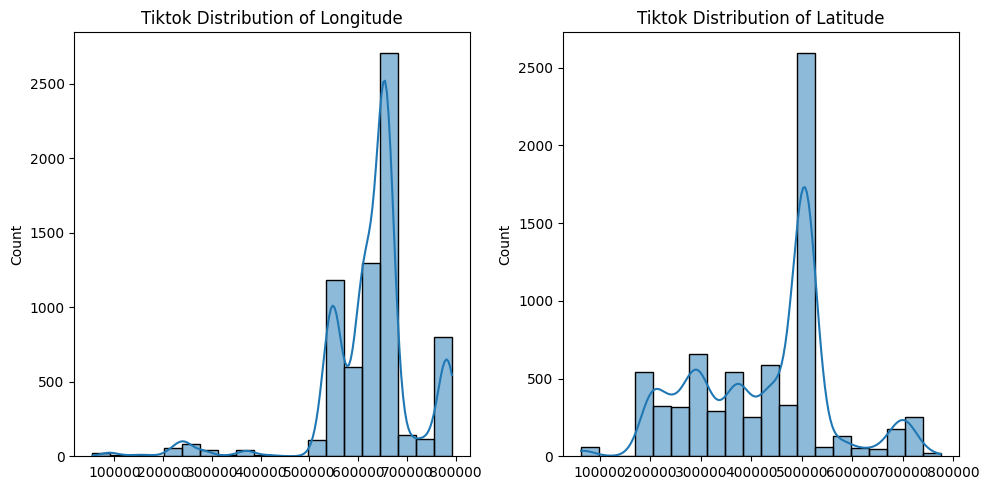

Twitter Longitude Skewness: -1.4326809416701314, Kurtosis: 5.00856987973844
Twitter Latitude Skewness: 0.18907380041097654, Kurtosis: -0.3433233685997026
Twitter Longitude: Best Distribution: norm, Parameters: (617434.4651216188, 112215.78965258937)
Twitter Latitude: Best Distribution: gamma, Parameters: (54.85225452302497, -633123.3040060973, 18850.531597631492)


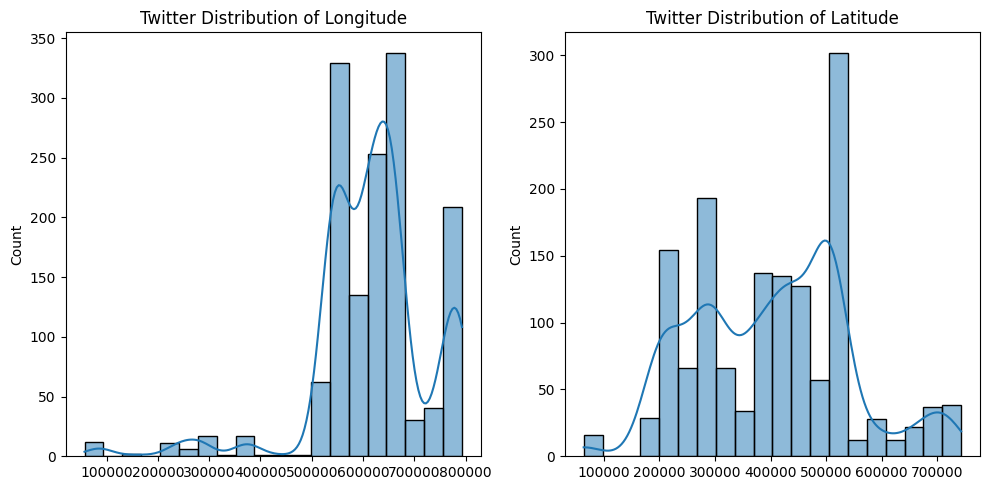

Twitter Georeferenced Longitude Skewness: -0.9851201950427251, Kurtosis: 3.2341319349964524
Twitter Georeferenced Latitude Skewness: 0.11804088484021844, Kurtosis: -0.3884167862894712
Twitter Georeferenced Longitude: Best Distribution: norm, Parameters: (632024.4951936754, 110916.45911290051)
Twitter Georeferenced Latitude: Best Distribution: gamma, Parameters: (143.64790726365231, -1239628.3768635476, 11457.095096148805)


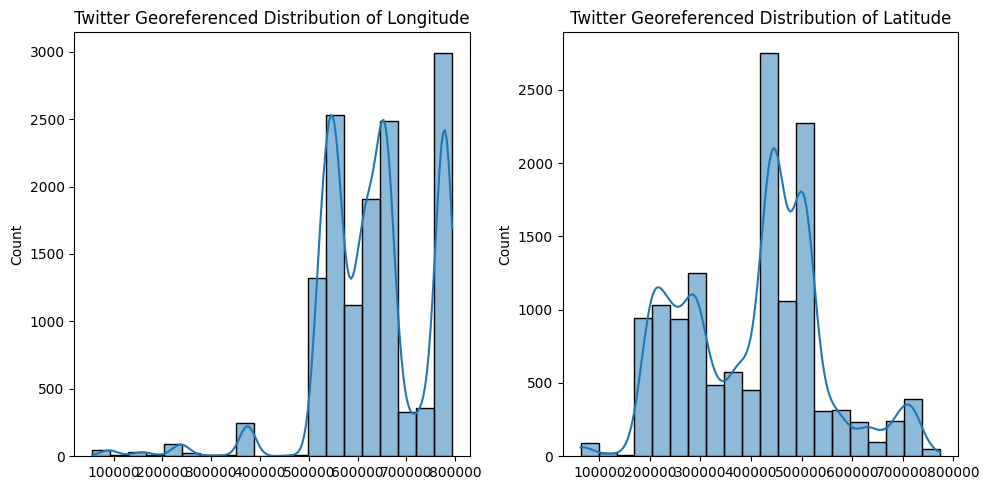

In [14]:
import numpy as np
from scipy.stats import skew, kurtosis, norm, expon, gamma
import seaborn as sns
import matplotlib.pyplot as plt

# Define a function to fit a distribution and calculate AIC
def fit_distribution(data):
    # Fit normal distribution
    params_norm = norm.fit(data)
    log_likelihood_norm = norm(*params_norm).logpdf(data).sum()
    aic_norm = -2 * log_likelihood_norm + 2 * len(params_norm)

    # Fit exponential distribution
    params_expon = expon.fit(data)
    log_likelihood_expon = expon(*params_expon).logpdf(data).sum()
    aic_expon = -2 * log_likelihood_expon + 2 * len(params_expon)

    # Fit gamma distribution
    params_gamma = gamma.fit(data)
    log_likelihood_gamma = gamma(*params_gamma).logpdf(data).sum()
    aic_gamma = -2 * log_likelihood_gamma + 2 * len(params_gamma)

    # Determine the best-fitting distribution based on AIC
    aics = {'norm': aic_norm, 'expon': aic_expon, 'gamma': aic_gamma}
    best_dist = min(aics, key=aics.get)

    return best_dist, locals()[f'params_{best_dist}']

# Loop through grouped data and analyze distributions
for source, group in grouped:
    # Extract longitude and latitude from your point dataset
    longitude = group.geometry.x
    latitude = group.geometry.y

    # Fit distributions to longitude and latitude data
    best_dist_long, params_long = fit_distribution(longitude)
    best_dist_lat, params_lat = fit_distribution(latitude)

    # Calculate skewness and kurtosis for longitude
    longitude_skewness = skew(longitude)
    longitude_kurtosis = kurtosis(longitude)

    # Calculate skewness and kurtosis for latitude
    latitude_skewness = skew(latitude)
    latitude_kurtosis = kurtosis(latitude)

    print(f'{source} Longitude Skewness: {longitude_skewness}, Kurtosis: {longitude_kurtosis}')
    print(f'{source} Latitude Skewness: {latitude_skewness}, Kurtosis: {latitude_kurtosis}')

    # Print the best-fitting distributions and their parameters
    print(f'{source} Longitude: Best Distribution: {best_dist_long}, Parameters: {params_long}')
    print(f'{source} Latitude: Best Distribution: {best_dist_lat}, Parameters: {params_lat}')

    # Plot histograms for longitude and latitude
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(longitude, kde=True, bins=20)
    plt.title(f'{source} Distribution of Longitude')

    plt.subplot(1, 2, 2)
    sns.histplot(latitude, kde=True, bins=20)
    plt.title(f'{source} Distribution of Latitude')

    plt.tight_layout()
    plt.show()


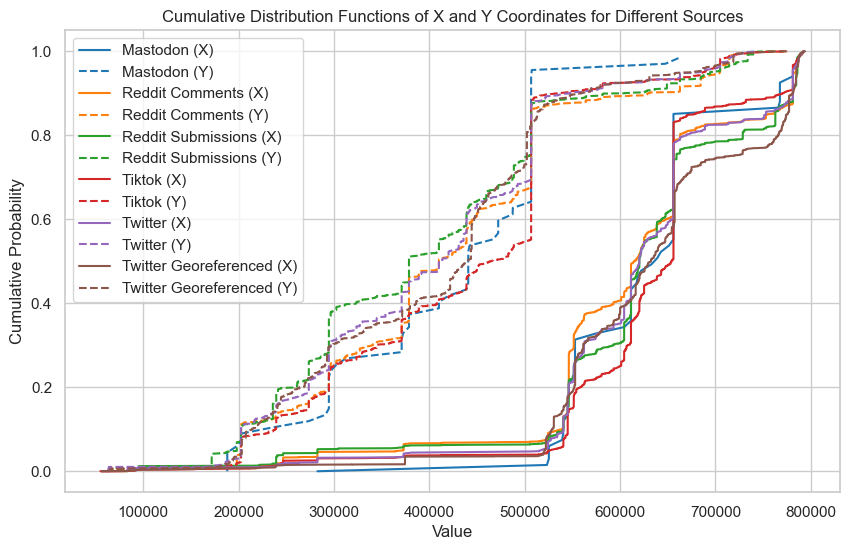

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns  # For KDE and CDF plots
import pandas as pd
import numpy as np

# Create a color palette with unique colors for each source
palette = sns.color_palette("tab10", len(grouped))

# Create a new figure
plt.figure(figsize=(10, 6))

# Iterate over each group and plot the CDFs for x and y coordinates
for i, (source, data) in enumerate(grouped):
    # Calculate CDF for x coordinates
    x_values = np.sort(data.geometry.x)
    x_cdf = np.arange(len(x_values)) / float(len(x_values))
    
    # Calculate CDF for y coordinates
    y_values = np.sort(data.geometry.y)
    y_cdf = np.arange(len(y_values)) / float(len(y_values))
    
    # Plot CDF for x coordinates with source-specific color
    plt.plot(x_values, x_cdf, label=f'{source} (X)', color=palette[i])
    
    # Plot CDF for y coordinates with source-specific color
    plt.plot(y_values, y_cdf, label=f'{source} (Y)', linestyle='--', color=palette[i])

# Add labels, title, and legend
plt.xlabel('Value')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution Functions of X and Y Coordinates for Different Sources')
plt.legend()

# Show plot
plt.show()


In [21]:
import pandas as pd
import geopandas as gpd
from scipy.stats import ks_2samp
import numpy as np

# Assuming gdf is your GeoDataFrame and 'source' is the column to group by
grouped = gdf.groupby("source")

# Get the unique groups
groups = list(grouped.groups.keys())

# Initialize matrices to store p-values for x and y coordinates
p_values_x = pd.DataFrame(np.nan, index=groups, columns=groups)
p_values_y = pd.DataFrame(np.nan, index=groups, columns=groups)

# Iterate over each pair of groups
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        group1 = groups[i]
        group2 = groups[j]
        
        data1 = grouped.get_group(group1)
        data2 = grouped.get_group(group2)
        
        # Extract the x and y coordinates
        x1 = data1.geometry.x
        y1 = data1.geometry.y
        x2 = data2.geometry.x
        y2 = data2.geometry.y
        
        # Apply the Kolmogorov-Smirnov test on x coordinates
        _, p_value_x = ks_2samp(x1, x2)
        
        # Apply the Kolmogorov-Smirnov test on y coordinates
        _, p_value_y = ks_2samp(y1, y2)
        
        # Store the p-values in the matrices
        p_values_x.at[group1, group2] = p_value_x
        p_values_x.at[group2, group1] = p_value_x
        p_values_y.at[group1, group2] = p_value_y
        p_values_y.at[group2, group1] = p_value_y

print("Cross-Correlation Matrix for X Coordinates (P-Values):")
print(p_values_x)
print("\nCross-Correlation Matrix for Y Coordinates (P-Values):")
print(p_values_y)


Cross-Correlation Matrix for X Coordinates (P-Values):
                       Mastodon  Reddit Comments  Reddit Submissions  \
Mastodon                    NaN     6.183790e-01        2.453027e-01   
Reddit Comments        0.618379              NaN        1.178643e-18   
Reddit Submissions     0.245303     1.178643e-18                 NaN   
Tiktok                 0.123568     5.977807e-72        4.581747e-30   
Twitter                0.694634     8.477712e-07        9.890364e-03   
Twitter Georeferenced  0.000032    5.932577e-141        2.723099e-51   

                              Tiktok       Twitter  Twitter Georeferenced  
Mastodon                1.235681e-01  6.946337e-01           3.186249e-05  
Reddit Comments         5.977807e-72  8.477712e-07          5.932577e-141  
Reddit Submissions      4.581747e-30  9.890364e-03           2.723099e-51  
Tiktok                           NaN  1.168059e-14          1.135860e-253  
Twitter                 1.168059e-14           NaN          

# KDE

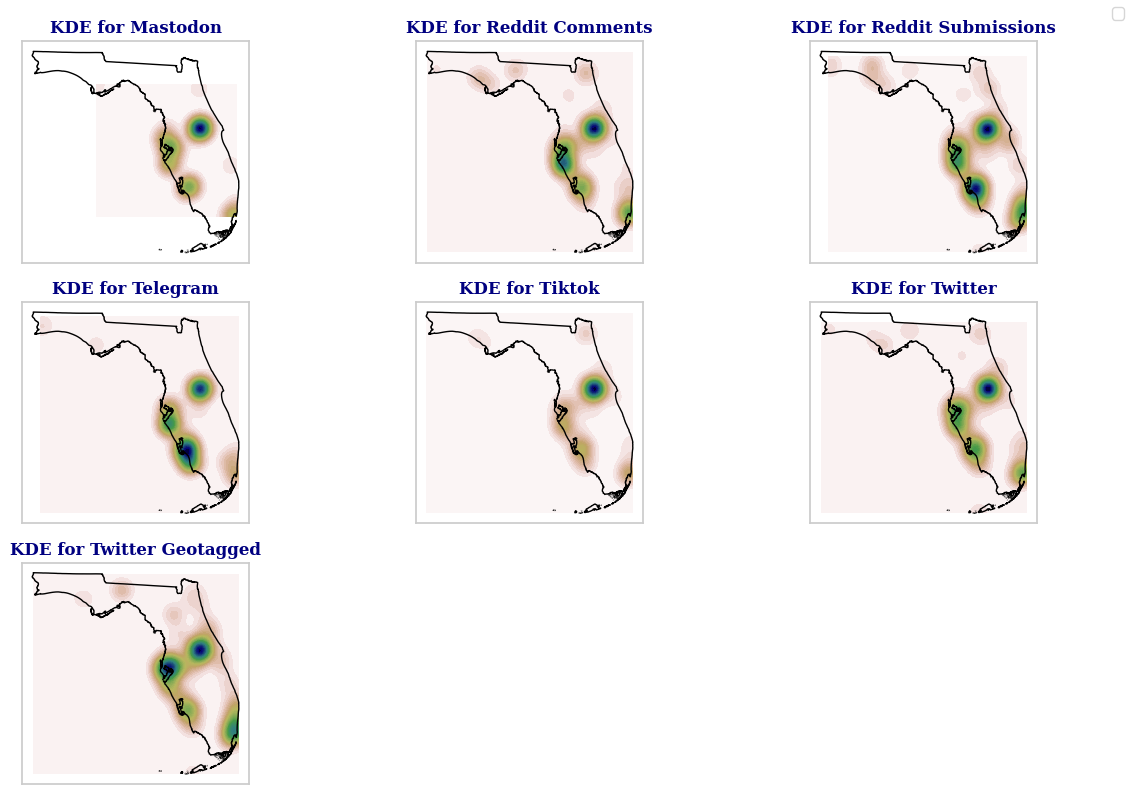

In [9]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import geopandas as gpd

# Load the border data
gpkg_file = "dataset/florida_boundary.gpkg"
border_data = gpd.read_file(gpkg_file, layer='border')

# Calculate the number of rows and columns for subplots based on the number of sources
num_sources = len(grouped)
num_cols = 3  # Adjust as needed
num_rows = (num_sources + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Iterate over each source and plot the KDE heatmap in the corresponding subplot
for idx, (source, group) in enumerate(grouped):
    # Define bandwidth (adjust as needed)
    coords = group.geometry.apply(lambda geom: (geom.x, geom.y))
    X = np.array(coords.tolist())
    bandwidth = 25000
    data = X

    # Fit KDE model to the data
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')  # Gaussian kernel
    kde.fit(data)

    # Generate grid of points for evaluation
    x_min, x_max = np.min(data[:, 0]), np.max(data[:, 0])
    y_min, y_max = np.min(data[:, 1]), np.max(data[:, 1])
    x_vals = np.linspace(x_min, x_max, 100)
    y_vals = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x_vals, y_vals)
    xy_grid = np.vstack([X.ravel(), Y.ravel()]).T

    # Evaluate KDE on the grid
    log_density = kde.score_samples(xy_grid)
    density = np.exp(log_density).reshape(X.shape)

    # Plot KDE heatmap in the corresponding subplot
    row_idx = idx // num_cols
    col_idx = idx % num_cols
    ax = axes[row_idx, col_idx]
    if density.max() > 0:
        ax.contourf(X, Y, density, cmap=plt.cm.gist_earth_r, levels=50)  # Adjust cmap and levels as desired
        ax.set_title(f'KDE for {source}', fontsize=12, fontweight='bold', color='navy')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        border_data.plot(ax=ax, color='none', edgecolor='black', linewidth=1)  # Add border
    else:
        ax.axis('off')  # Turn off empty subplots

# Hide any remaining empty subplots
for i in range(num_sources, len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

# Add legend for plots
handles, labels = axes[0, 0].get_legend_handles_labels()  # Get handles and labels from the first subplot
fig.legend(handles, labels, loc='upper right')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

C:\Users\vrace\AppData\Local\Temp\ipykernel_28908\3999865403.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, ax=ax, cmap="viridis_r", shade=True, thresh=0, levels=10, cbar=True)
C:\Users\vrace\AppData\Local\Temp\ipykernel_28908\3999865403.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, ax=ax, cmap="viridis_r", shade=True, thresh=0, levels=10, cbar=True)
C:\Users\vrace\AppData\Local\Temp\ipykernel_28908\3999865403.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=x, y=y, ax=ax, cmap="viridis_r", shade=True, thresh=0, levels=10, cbar=True)
C:\Users\vrace\AppData\Local\Temp\ipykernel_28908

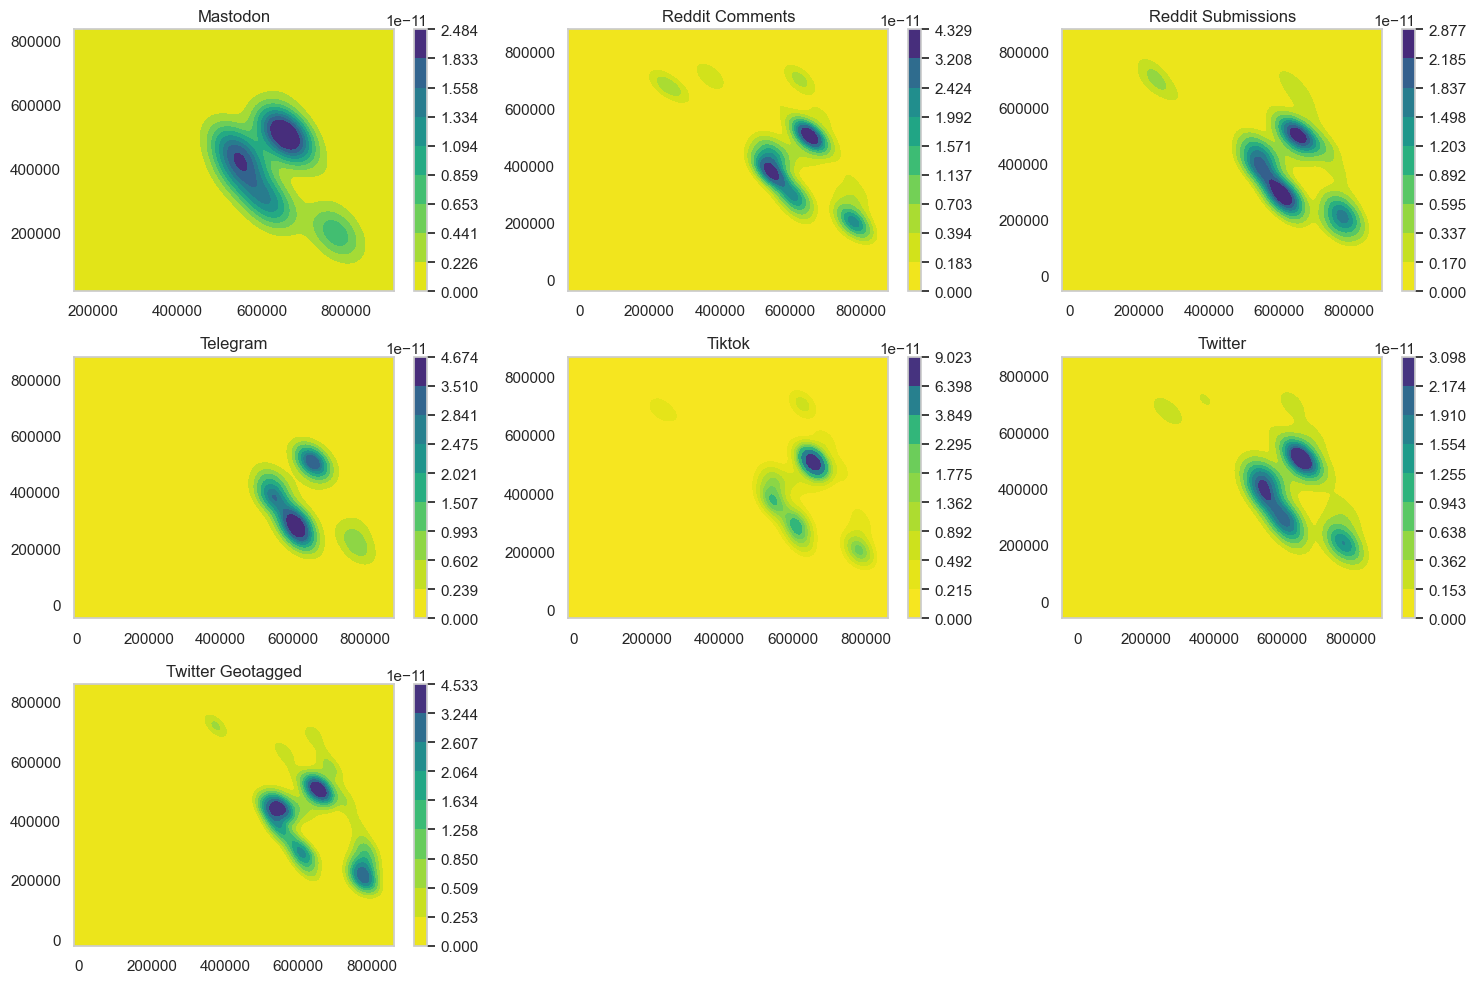

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# I assume `grouped` is already defined

# Calculate the number of rows and columns for subplots based on the number of sources
num_sources = len(grouped)
num_cols = 3  # Adjust as needed
num_rows = (num_sources + num_cols - 1) // num_cols
# Load the border data
gpkg_file = r"C:\Users\vrace\OneDrive - Universität Salzburg\master\dataqgis\florida_borded.gpkg"
border_data = gpd.read_file(gpkg_file, layer='border')
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Loop through the grouped data and plot KDE plot on each subplot
for i, (source, group) in enumerate(grouped, start=1):
    # Define bandwidth (adjust as needed)
    coords = group.geometry.apply(lambda geom: (geom.x, geom.y))

    # Convert coordinates to numpy array for clustering
    data = np.array(coords.tolist())
    x = data[:, 0]  # Extract x coordinates
    y = data[:, 1]

    # Calculate subplot indices
    row_idx = (i - 1) // num_cols
    col_idx = (i - 1) % num_cols

    # Plot KDE plot on the corresponding subplot
    ax = axes[row_idx, col_idx]
    sns.kdeplot(x=x, y=y, ax=ax, cmap="viridis_r", shade=True, thresh=0, levels=10, cbar=True)

    # Set title
    ax.set_title(f'{source}')

# Hide any remaining empty subplots
for i in range(num_sources, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


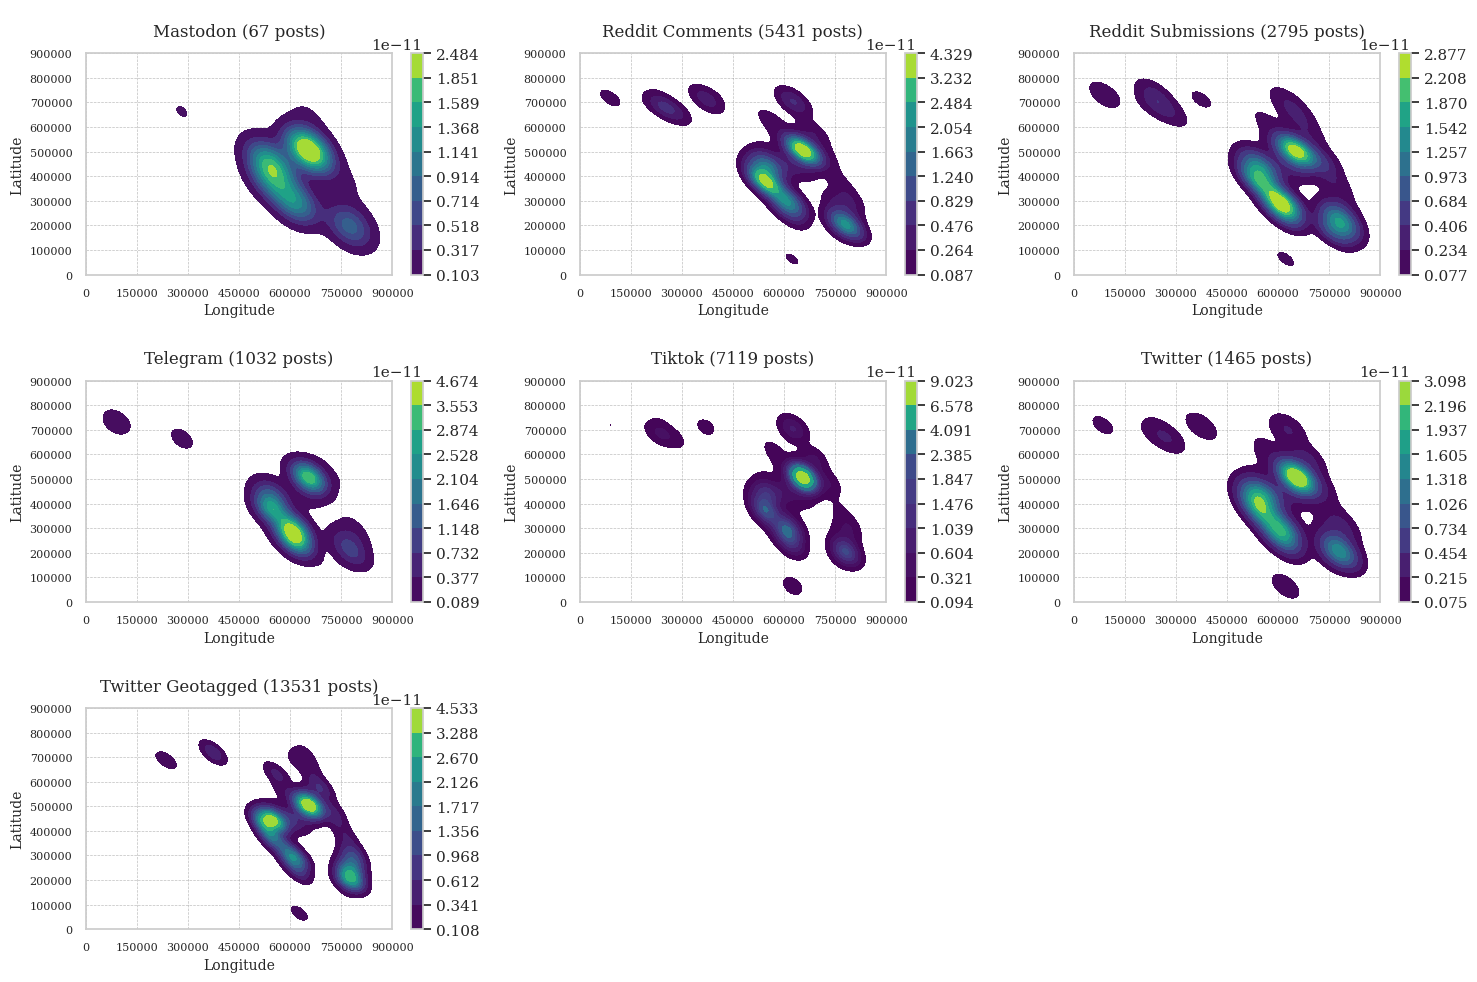

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns  # For KDE and CDF plots
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator  # Import MaxNLocator

# Set style for KDE and CDF plot
color_map = {
    'Twitter': 'cornflowerblue',
    'Tiktok': 'black',
    'Reddit Submissions': 'darkorange',
    'Reddit Comments': 'gold',
    'Telegram': 'darkblue',
    'Mastodon': 'purple',
    'Twitter Geotagged': 'red',
}

# Calculate the number of rows and columns for subplots based on the number of sources
num_sources = len(grouped)
num_cols = 3  # Adjust as needed
num_rows = (num_sources + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Loop through the grouped data and plot KDE plot on each subplot
for i, (source, group) in enumerate(grouped):
    # Extract x and y coordinates
    group['x'] = group.geometry.x
    group['y'] = group.geometry.y

    ax_joint = axes[i]
    ax_marg_x = ax_joint.inset_axes([0, 1.1, 1, 0.1], sharex=ax_joint)
    ax_marg_y = ax_joint.inset_axes([1.1, 0, 0.1, 1], sharey=ax_joint)
    
    # Main KDE plot
    kde = sns.kdeplot(data=group, x='x', y='y', fill=True, ax=ax_joint, cmap='viridis')
    
    # Capture the contour set to create a color bar
    cset = kde.collections[0]
    
    ax_marg_x.axis('off')
    ax_marg_y.axis('off')
    
    ax_joint.set_xlim(0, 900000)
    ax_joint.set_ylim(0, 900000)
    
    ax_joint.set_title(f'{source} ({len(group)} posts)', fontsize=12)
    ax_joint.set_xlabel('Longitude', fontsize=10)
    ax_joint.set_ylabel('Latitude', fontsize=10)
    
    ax_joint.tick_params(axis='x', labelsize=8)
    ax_joint.tick_params(axis='y', labelsize=8)
    
    ax_joint.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    
    # Adjust x-axis ticks
    ax_joint.xaxis.set_major_locator(MaxNLocator(nbins=6))  # Adjust the number of bins as needed
    
    # Add color bar
    fig.colorbar(cset, ax=ax_joint, orientation='vertical')

# Hide any remaining empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()


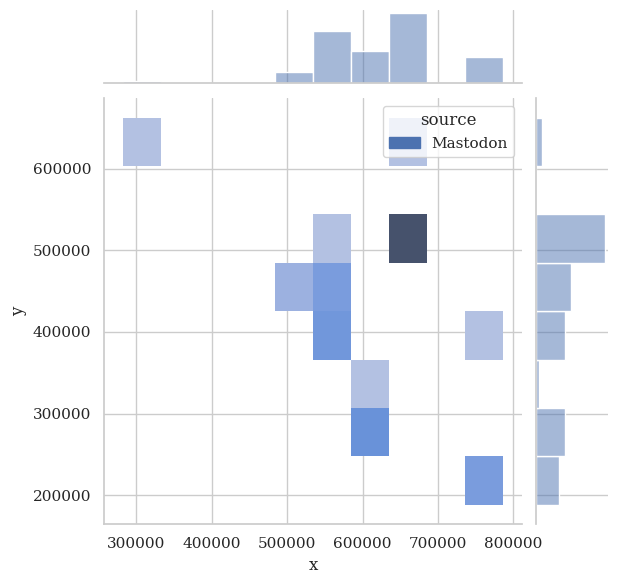

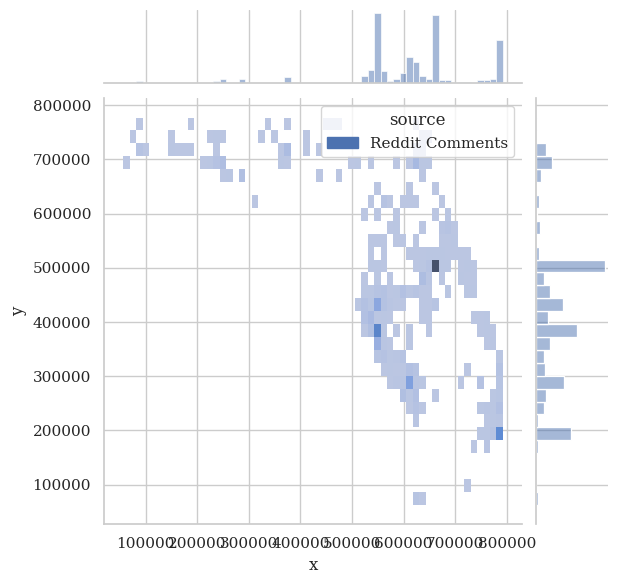

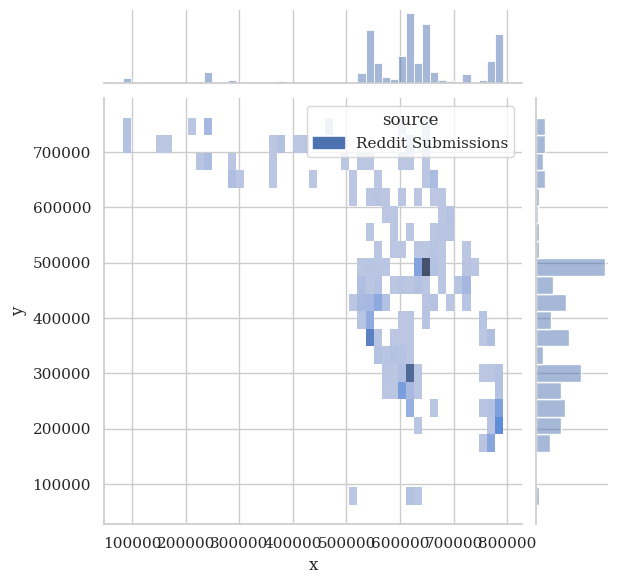

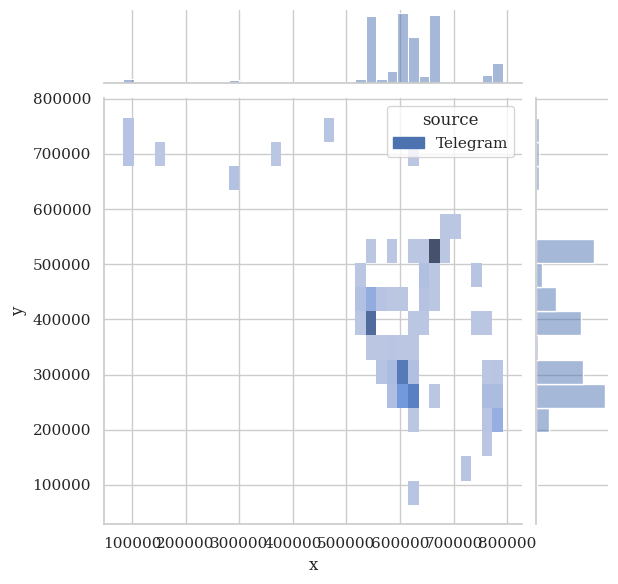

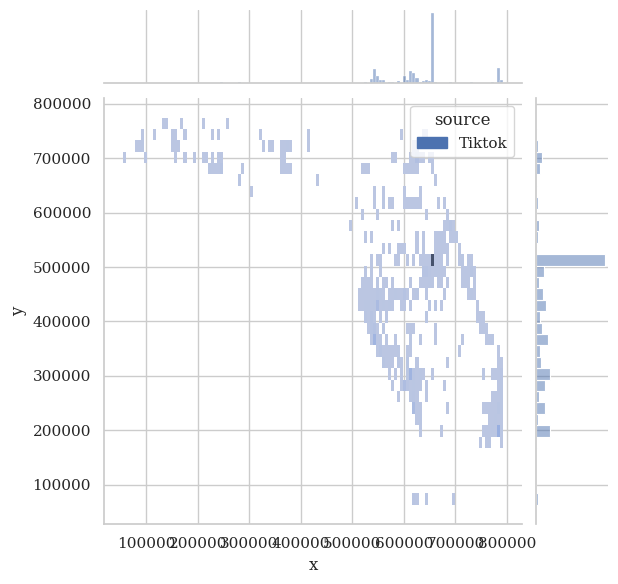

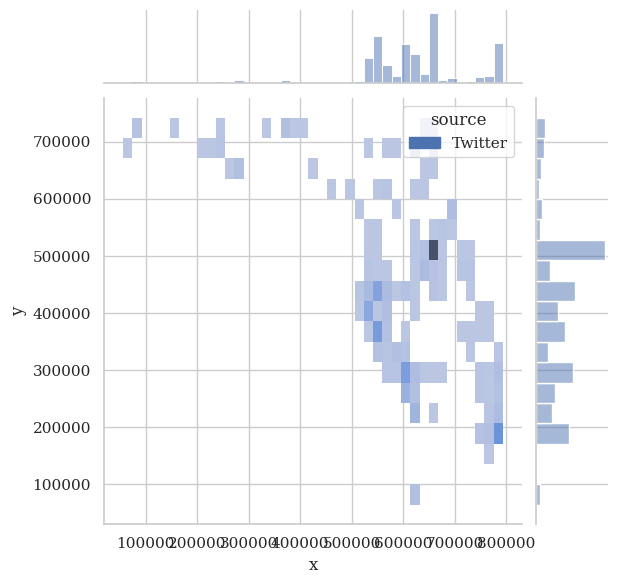

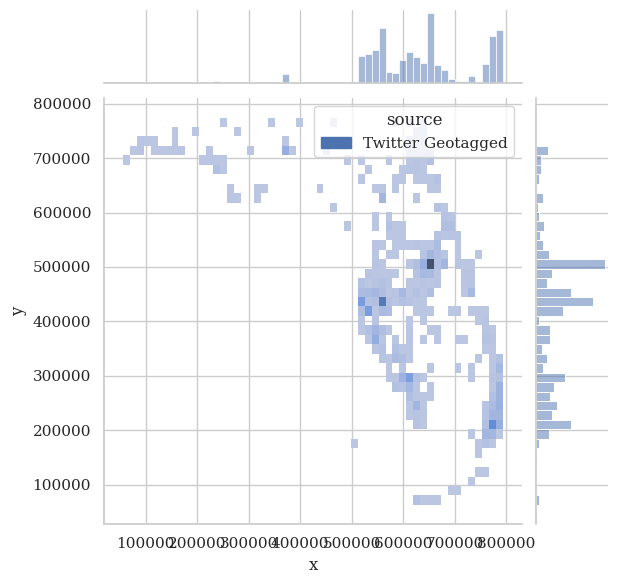

In [59]:
for group, gdf in grouped:

    # Extract x and y coordinates
    gdf['x'] = gdf.geometry.x
    gdf['y'] = gdf.geometry.y


    sns.jointplot(data=gdf, x=gdf['x'], y=gdf['y'], hue="source", kind="hist")    

# Multiscale correlation

In [ ]:
florida_df = pd.read_csv("dataset/geocoded.csv")
florida_df.drop(['Unnamed: 0'], axis=1, inplace=True)
# Reproject and make it gdf
geometry = [Point(lon, lat) for lon, lat in zip(florida_df['longitude'], florida_df['latitude'])]
gdf = gpd.GeoDataFrame(florida_df, geometry=geometry, crs='EPSG:4326')
proj_crs = 'EPSG:3086'
gdf = gdf.to_crs(proj_crs)
grouped = gdf.groupby("source")


# Chloropleth maps - Counties and csnsus divisions

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445:

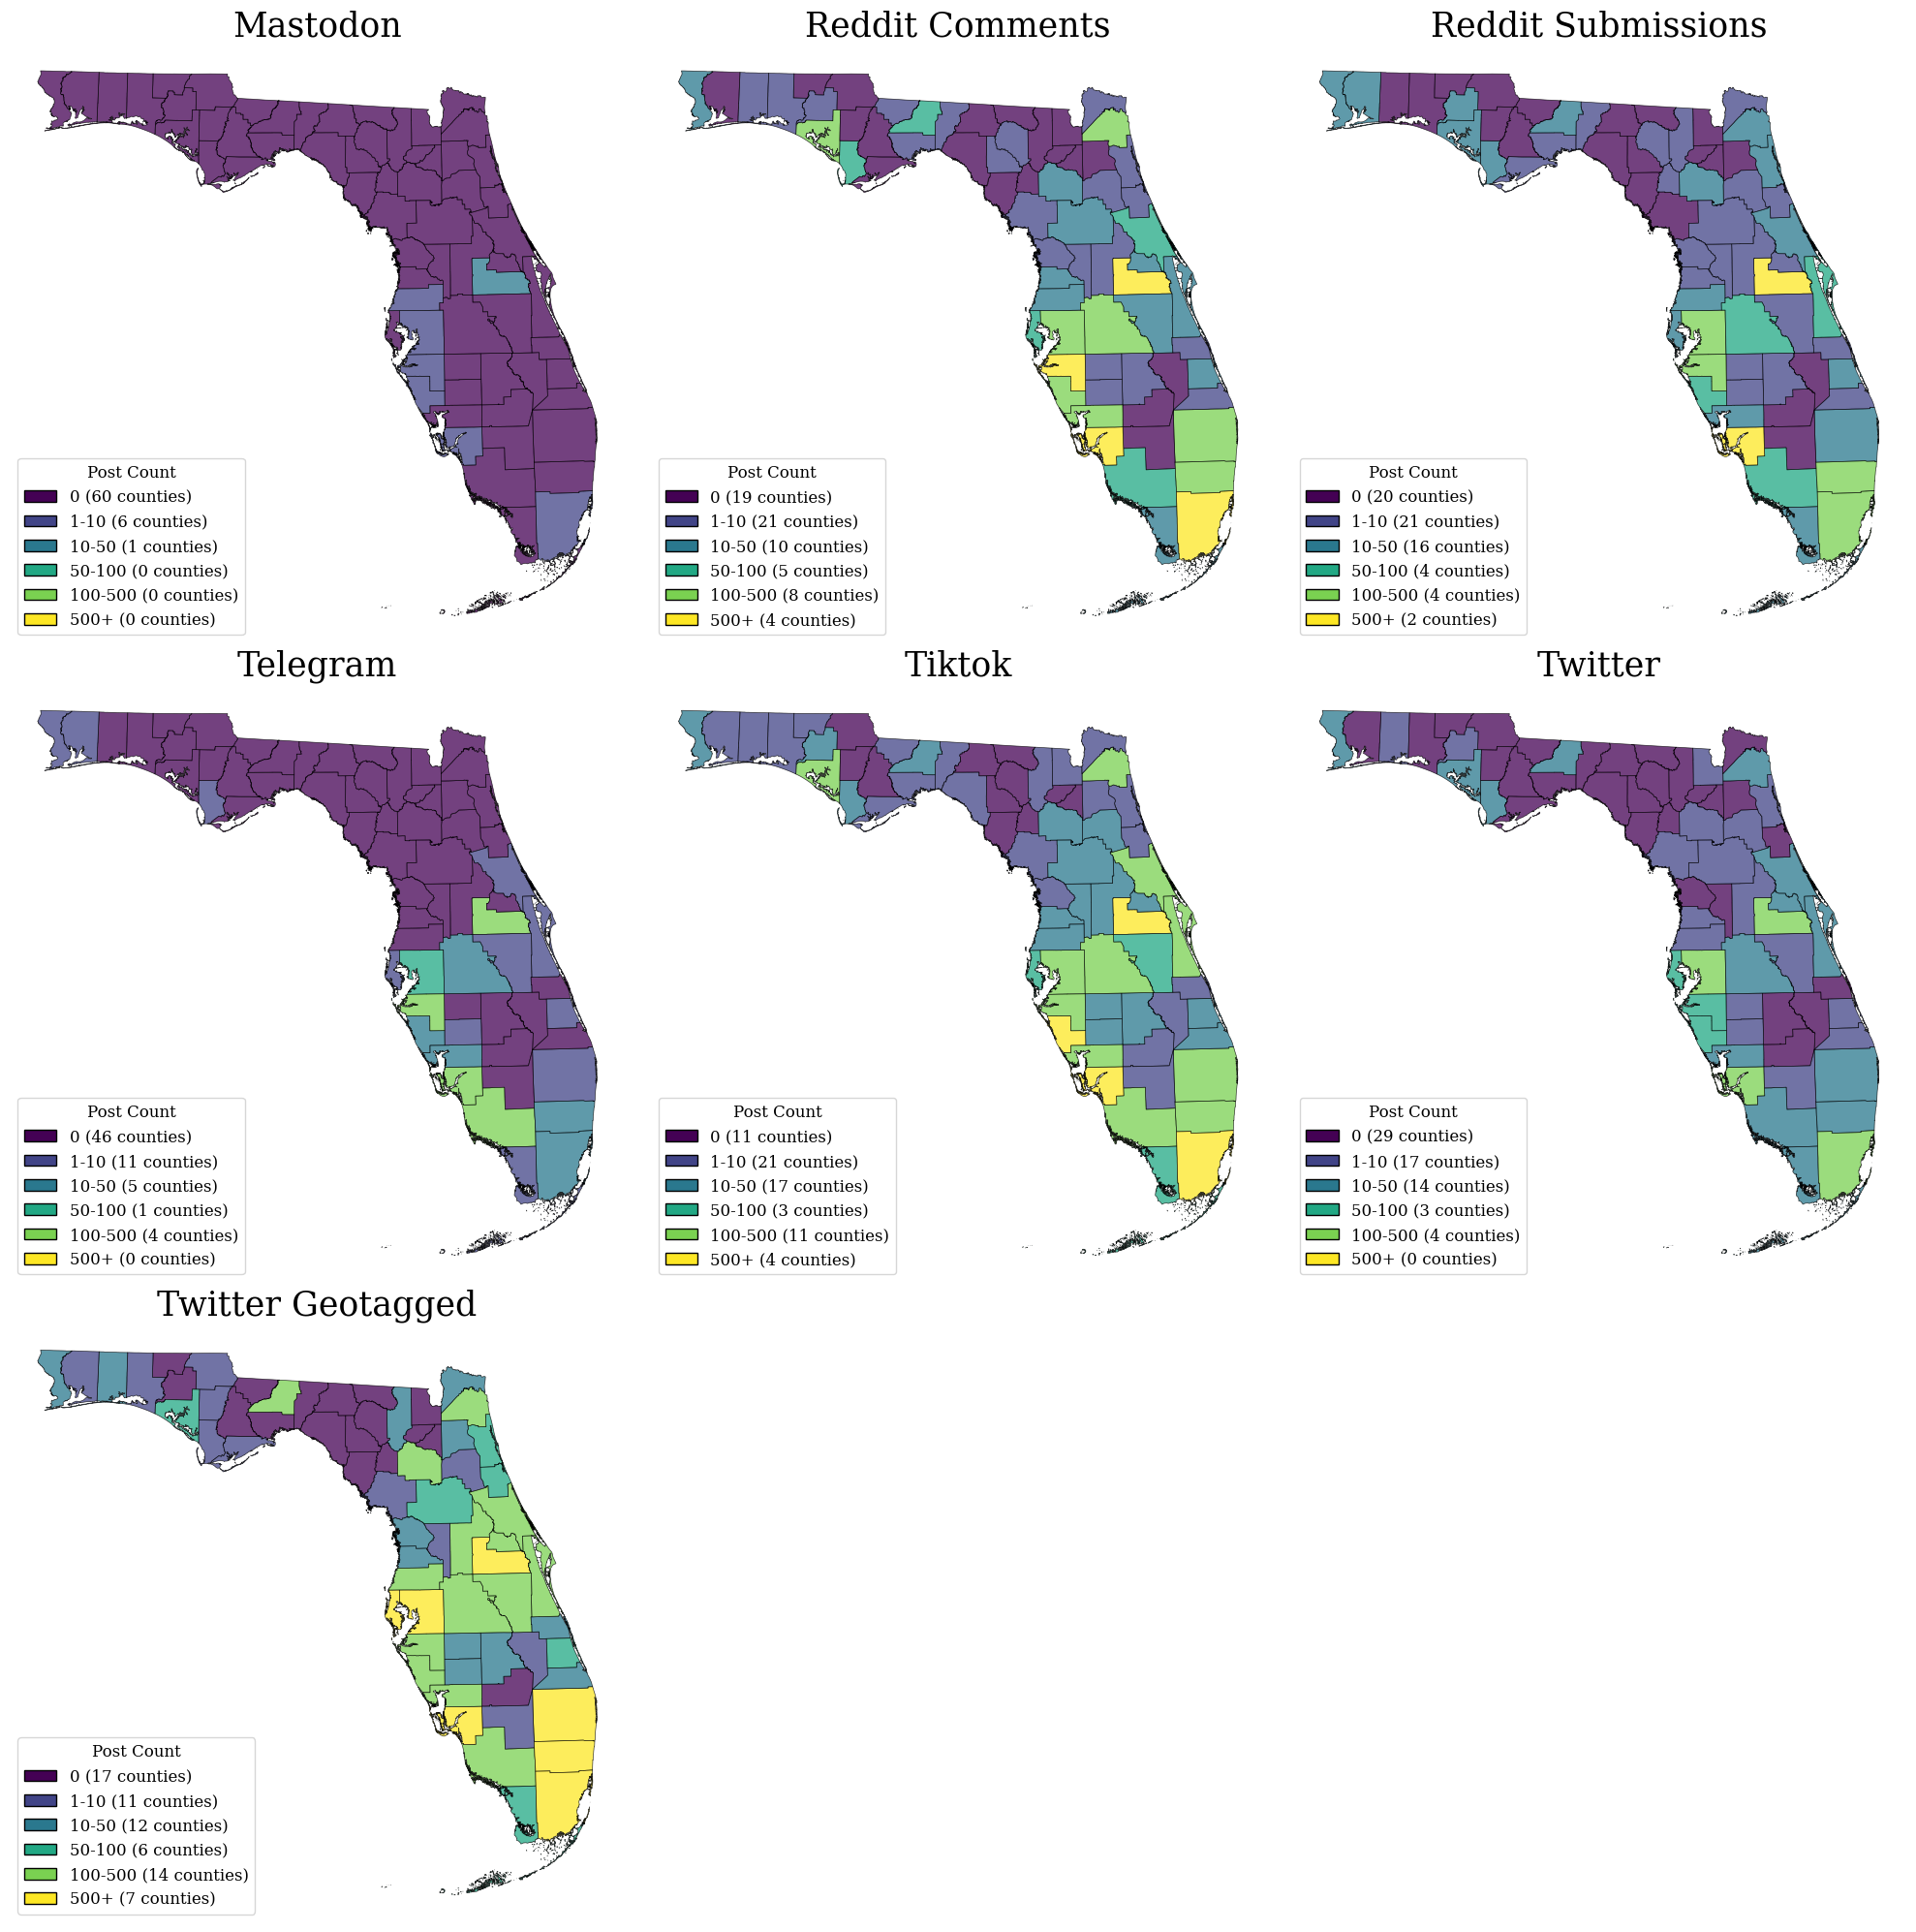

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch


points_gdf = gdf

# Load Florida counties GeoDataFrame
counties_gdf = gpd.read_file('dataset/counties.gpkg')
proj_crs = 'EPSG:3086'
counties_gdf = counties_gdf.to_crs(proj_crs)

# Get unique values in the "source" column
unique_sources = points_gdf['source'].unique()

# List to store GeoDataFrames for each source
source_gdfs = []

# Iterate over each unique source
for source in unique_sources:
    # Filter points for the current source
    points_subset = points_gdf[points_gdf['source'] == source]
    
    # Perform spatial join between points and counties for the current source
    points_in_counties = gpd.sjoin(counties_gdf, points_subset, how='inner', op='contains')
    
    # Calculate number of points in each county for the current source
    point_counts = points_in_counties.groupby('NAME').size().reset_index(name='point_count')
    
    # Merge point counts with counties GeoDataFrame
    source_county_gdf = pd.merge(counties_gdf, point_counts, on='NAME', how='left')
    
    # Fill missing values with 0 (for counties with no points for the current source)
    source_county_gdf['point_count'].fillna(0, inplace=True)
    
    # Add "source" column from points_gdf
    source_county_gdf['source'] = source
    
    # Append GeoDataFrame for the current source to the list
    source_gdfs.append(source_county_gdf)

# Concatenate GeoDataFrames for all sources
final_gdf = pd.concat(source_gdfs, ignore_index=True)

# Define custom bin edges and labels
bin_edges = [0, 1, 10, 50, 100, 500, np.inf]
bin_labels = ['0', '1-10', '10-50', '50-100', '100-500', '500+']

# Number of sources
num_sources = len(unique_sources)

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
# Set the font family
plt.rcParams['font.family'] = 'sans-serif'


for ax, (source, data) in zip(axes, final_gdf.groupby("source")):
    # Bin the data manually
    data["binned"] = pd.cut(data["point_count"], bins=bin_edges, labels=bin_labels, include_lowest=True)
    
    # Plot the data
    data.plot(
        column="binned",
        cmap="viridis",
        edgecolor="black",
        linewidth=0.5,
        alpha=0.75,
        legend=False,
        ax=ax,
    )
    
    # Remove axis for clean plot
    ax.set_axis_off()
    
    # Create custom legend
    norm = Normalize(vmin=0, vmax=len(bin_labels) - 1)
    sm = ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    # Calculate the count of counties falling within each bin
    county_counts = data.groupby("binned").size()
    # print(county_counts)

    # Create custom legend with county counts
    legend_elements_with_counts = [
        Patch(facecolor=sm.to_rgba(i), edgecolor='black', label=f"{label} ({county_counts.get(label, 0)} counties)")
        for i, label in enumerate(bin_labels)
    ]

    # Update legend with county counts{int(data["point_count"].max())}
    ax.legend(handles=legend_elements_with_counts, title=f"Post Count", loc='lower left', frameon=True, fontsize='large',  title_fontsize='large')
    
    # Add title to the plot
    ax.set_title(f"{source}", fontsize=25)
    

# Hide any remaining empty subplots
for i in range(num_sources, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445:

55
53
47
57
30
56
                    Mastodon  Reddit Comments  Reddit Submissions   Twitter  \
Mastodon            1.000000         0.912104            0.894314  0.945893   
Reddit Comments     0.912104         1.000000            0.907582  0.948506   
Reddit Submissions  0.894314         0.907582            1.000000  0.942852   
Twitter             0.945893         0.948506            0.942852  1.000000   
Tiktok              0.939591         0.894453            0.842220  0.931531   
Telegram            0.813220         0.829083            0.922970  0.862816   
Twitter Geotagged   0.814594         0.836331            0.823015  0.895596   

                      Tiktok  Telegram  Twitter Geotagged  
Mastodon            0.939591  0.813220           0.814594  
Reddit Comments     0.894453  0.829083           0.836331  
Reddit Submissions  0.842220  0.922970           0.823015  
Twitter             0.931531  0.862816           0.895596  
Tiktok              1.000000  0.792483           

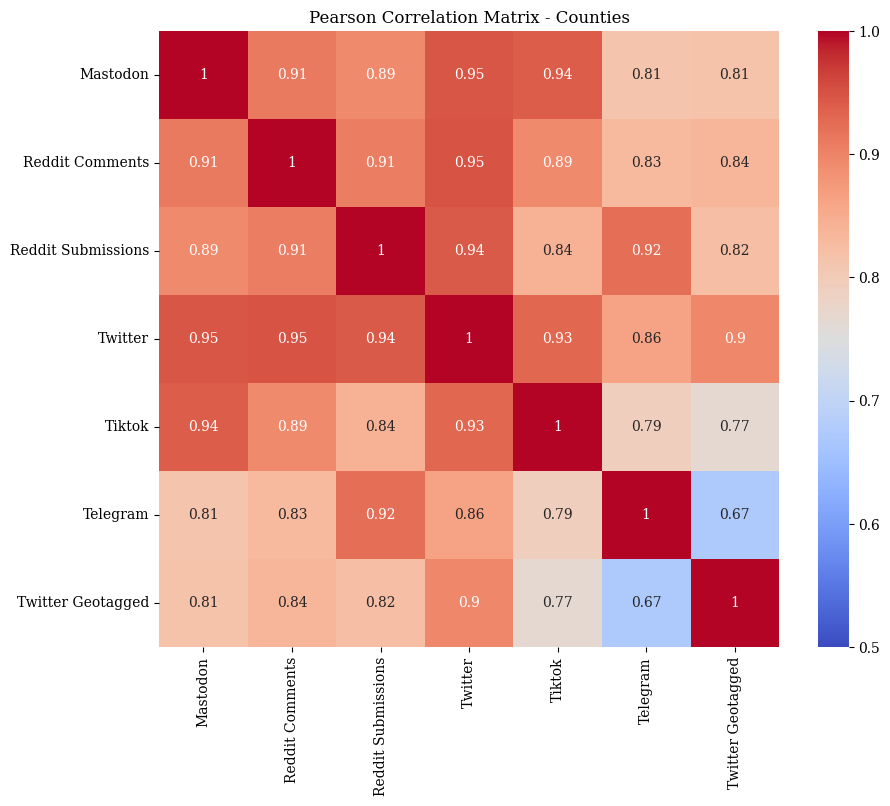

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load point GeoDataFrame
points_gdf = gdf

# Load Florida counties GeoDataFrame
counties_gdf = gpd.read_file('dataset/counties.gpkg')
proj_crs = 'EPSG:3086'
counties_gdf = counties_gdf.to_crs(proj_crs)

# Get unique values in the "source" column
unique_sources = points_gdf['source'].unique()

# List to store point counts for each source
source_dfs = []

# Iterate over each unique source
for source in unique_sources:
    # Filter points for the current source
    points_subset = points_gdf[points_gdf['source'] == source]
    
    # Perform spatial join between points and counties for the current source
    points_in_counties = gpd.sjoin(counties_gdf, points_subset, how='inner', op='contains')
    
    # Calculate number of points in each county for the current source
    point_counts = points_in_counties.groupby('NAME').size().reset_index(name=source)
    
    # Merge point counts with counties GeoDataFrame
    source_dfs.append(point_counts)



# Combine all sources into a single DataFrame
combined_df = source_dfs[0]
for df in source_dfs[1:]:
    print(len(df))
    combined_df = combined_df.merge(df, on='NAME', how='outer')

# Fill missing values with 0 (for counties with no points for a given source)
combined_df.fillna(0, inplace=True)

# Compute Pearson correlation coefficient matrix, excluding the 'NAME' column
correlation_matrix = combined_df.drop(columns=['NAME']).corr(method='pearson')

print(correlation_matrix)

# Compute and print Pearson's r for each pair of sources
for i, source1 in enumerate(unique_sources):
    for j, source2 in enumerate(unique_sources):
        if i < j:
            r, p_value = pearsonr(combined_df[source1], combined_df[source2])
            print(f"Pearson's r between {source1} and {source2}: {r:.4f}, p-value: {p_value:.4e}")

# Optional: visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0.5, vmax=1)
plt.title("Pearson Correlation Matrix - Counties")
plt.show()


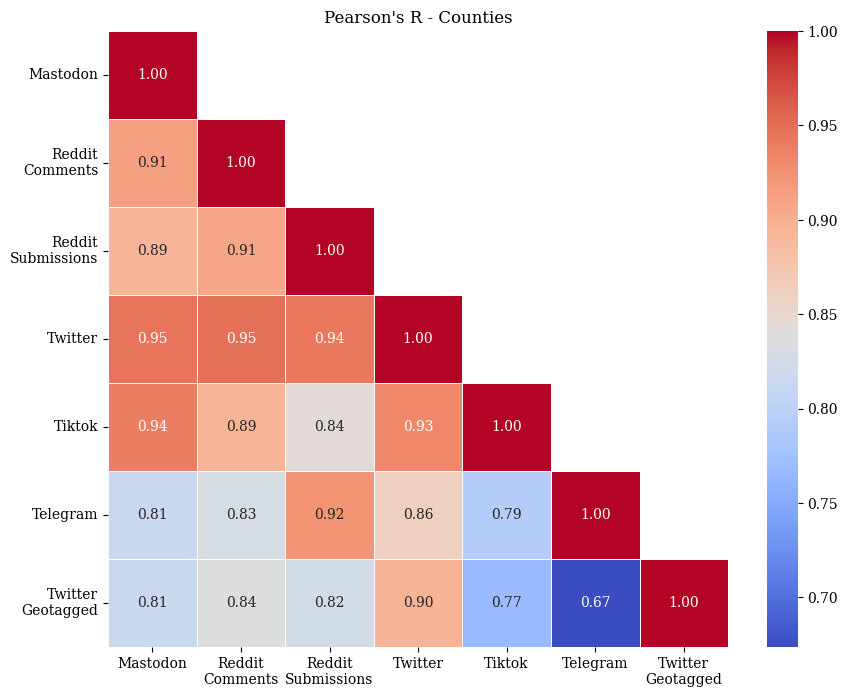

In [ ]:
correlation_matrix.index = correlation_matrix.index.str.replace(' ', '\n')
correlation_matrix.columns = correlation_matrix.columns.str.replace(' ', '\n')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  )
plt.title("Pearson's R - Counties")
plt.xlabel('')
plt.ylabel('')
plt.yticks(rotation = 0)
plt.show()

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445:

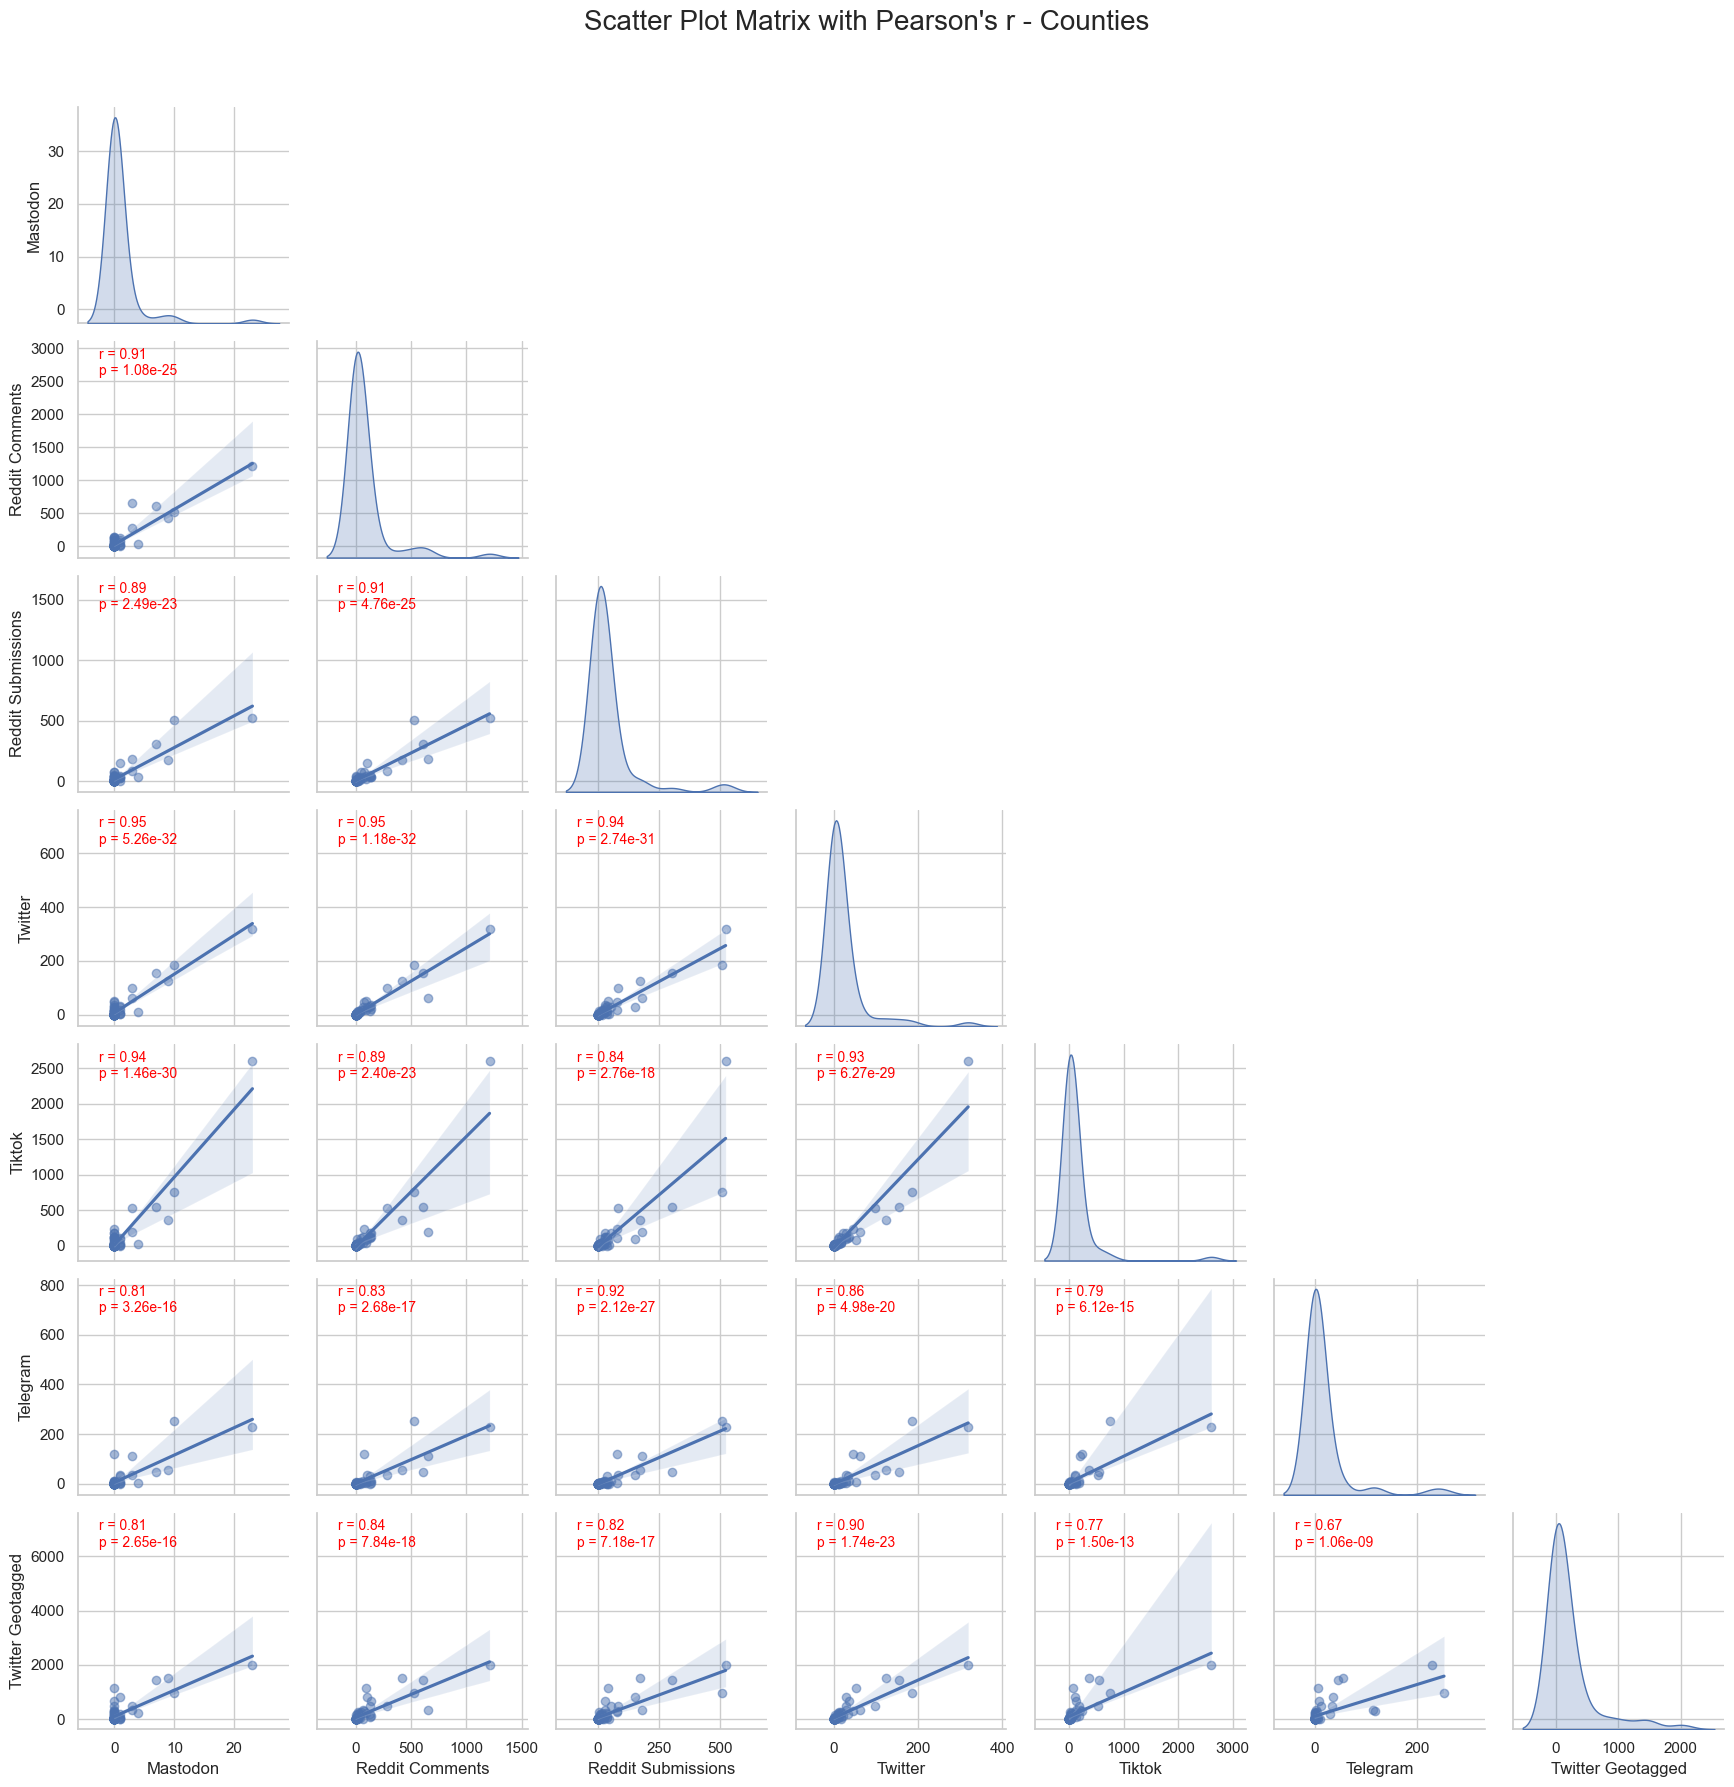

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
import geopandas as gpd

# Load point GeoDataFrame (replace this with your actual data loading code)
points_gdf = gdf

# Load Florida counties GeoDataFrame (replace this with your actual file path)
counties_gdf = gpd.read_file('dataset/counties.gpkg')
proj_crs = 'EPSG:3086'
counties_gdf = counties_gdf.to_crs(proj_crs)

# Get unique values in the "source" column
unique_sources = points_gdf['source'].unique()

# List to store dataframes for each source
source_dfs = []

# Iterate over each unique source
for source in unique_sources:
    # Filter points for the current source
    points_subset = points_gdf[points_gdf['source'] == source]
    
    # Perform spatial join between points and counties for the current source
    points_in_counties = gpd.sjoin(counties_gdf, points_subset, how='inner', op='contains')
    
    # Calculate number of points in each county for the current source
    point_counts = points_in_counties.groupby('NAME').size().reset_index(name=source)
    
    # Merge point counts with counties GeoDataFrame
    source_dfs.append(point_counts.set_index('NAME'))

# Concatenate DataFrames for all sources
merged_df = pd.concat(source_dfs, axis=1).fillna(0)

# Calculate Pearson correlation coefficients and p-values
pearson_results = {}
for source1 in unique_sources:
    for source2 in unique_sources:
        if source1 != source2:
            r, p = pearsonr(merged_df[source1], merged_df[source2])
            pearson_results[(source1, source2)] = (r, p)

# Create pair plot with Pearson correlation coefficients annotated
g = sns.pairplot(merged_df, kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.5}}, diag_kws={'shade': True})

# Mask the lower-right triangle (reverse of previous masking)
for i in range(len(unique_sources)):
    for j in range(len(unique_sources)):
        if i < j:
            g.axes[i, j].set_visible(False)

# Add correlation coefficients and p-values to the plots
for i, source1 in enumerate(unique_sources):
    for j, source2 in enumerate(unique_sources):
        if i != j:
            ax = g.axes[i, j]
            r, p = pearson_results[(source1, source2)]
            ax.annotate(f'r = {r:.2f}\np = {p:.2e}', xy=(0.1, 0.9), xycoords='axes fraction', ha='left', va='center', fontsize=10, color='red')

# Adjust the plot title
plt.suptitle("Scatter Plot Matrix with Pearson's r - Counties", y=1.02, fontsize=20)

plt.tight_layout()
plt.show()



## County subdivisions

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445:

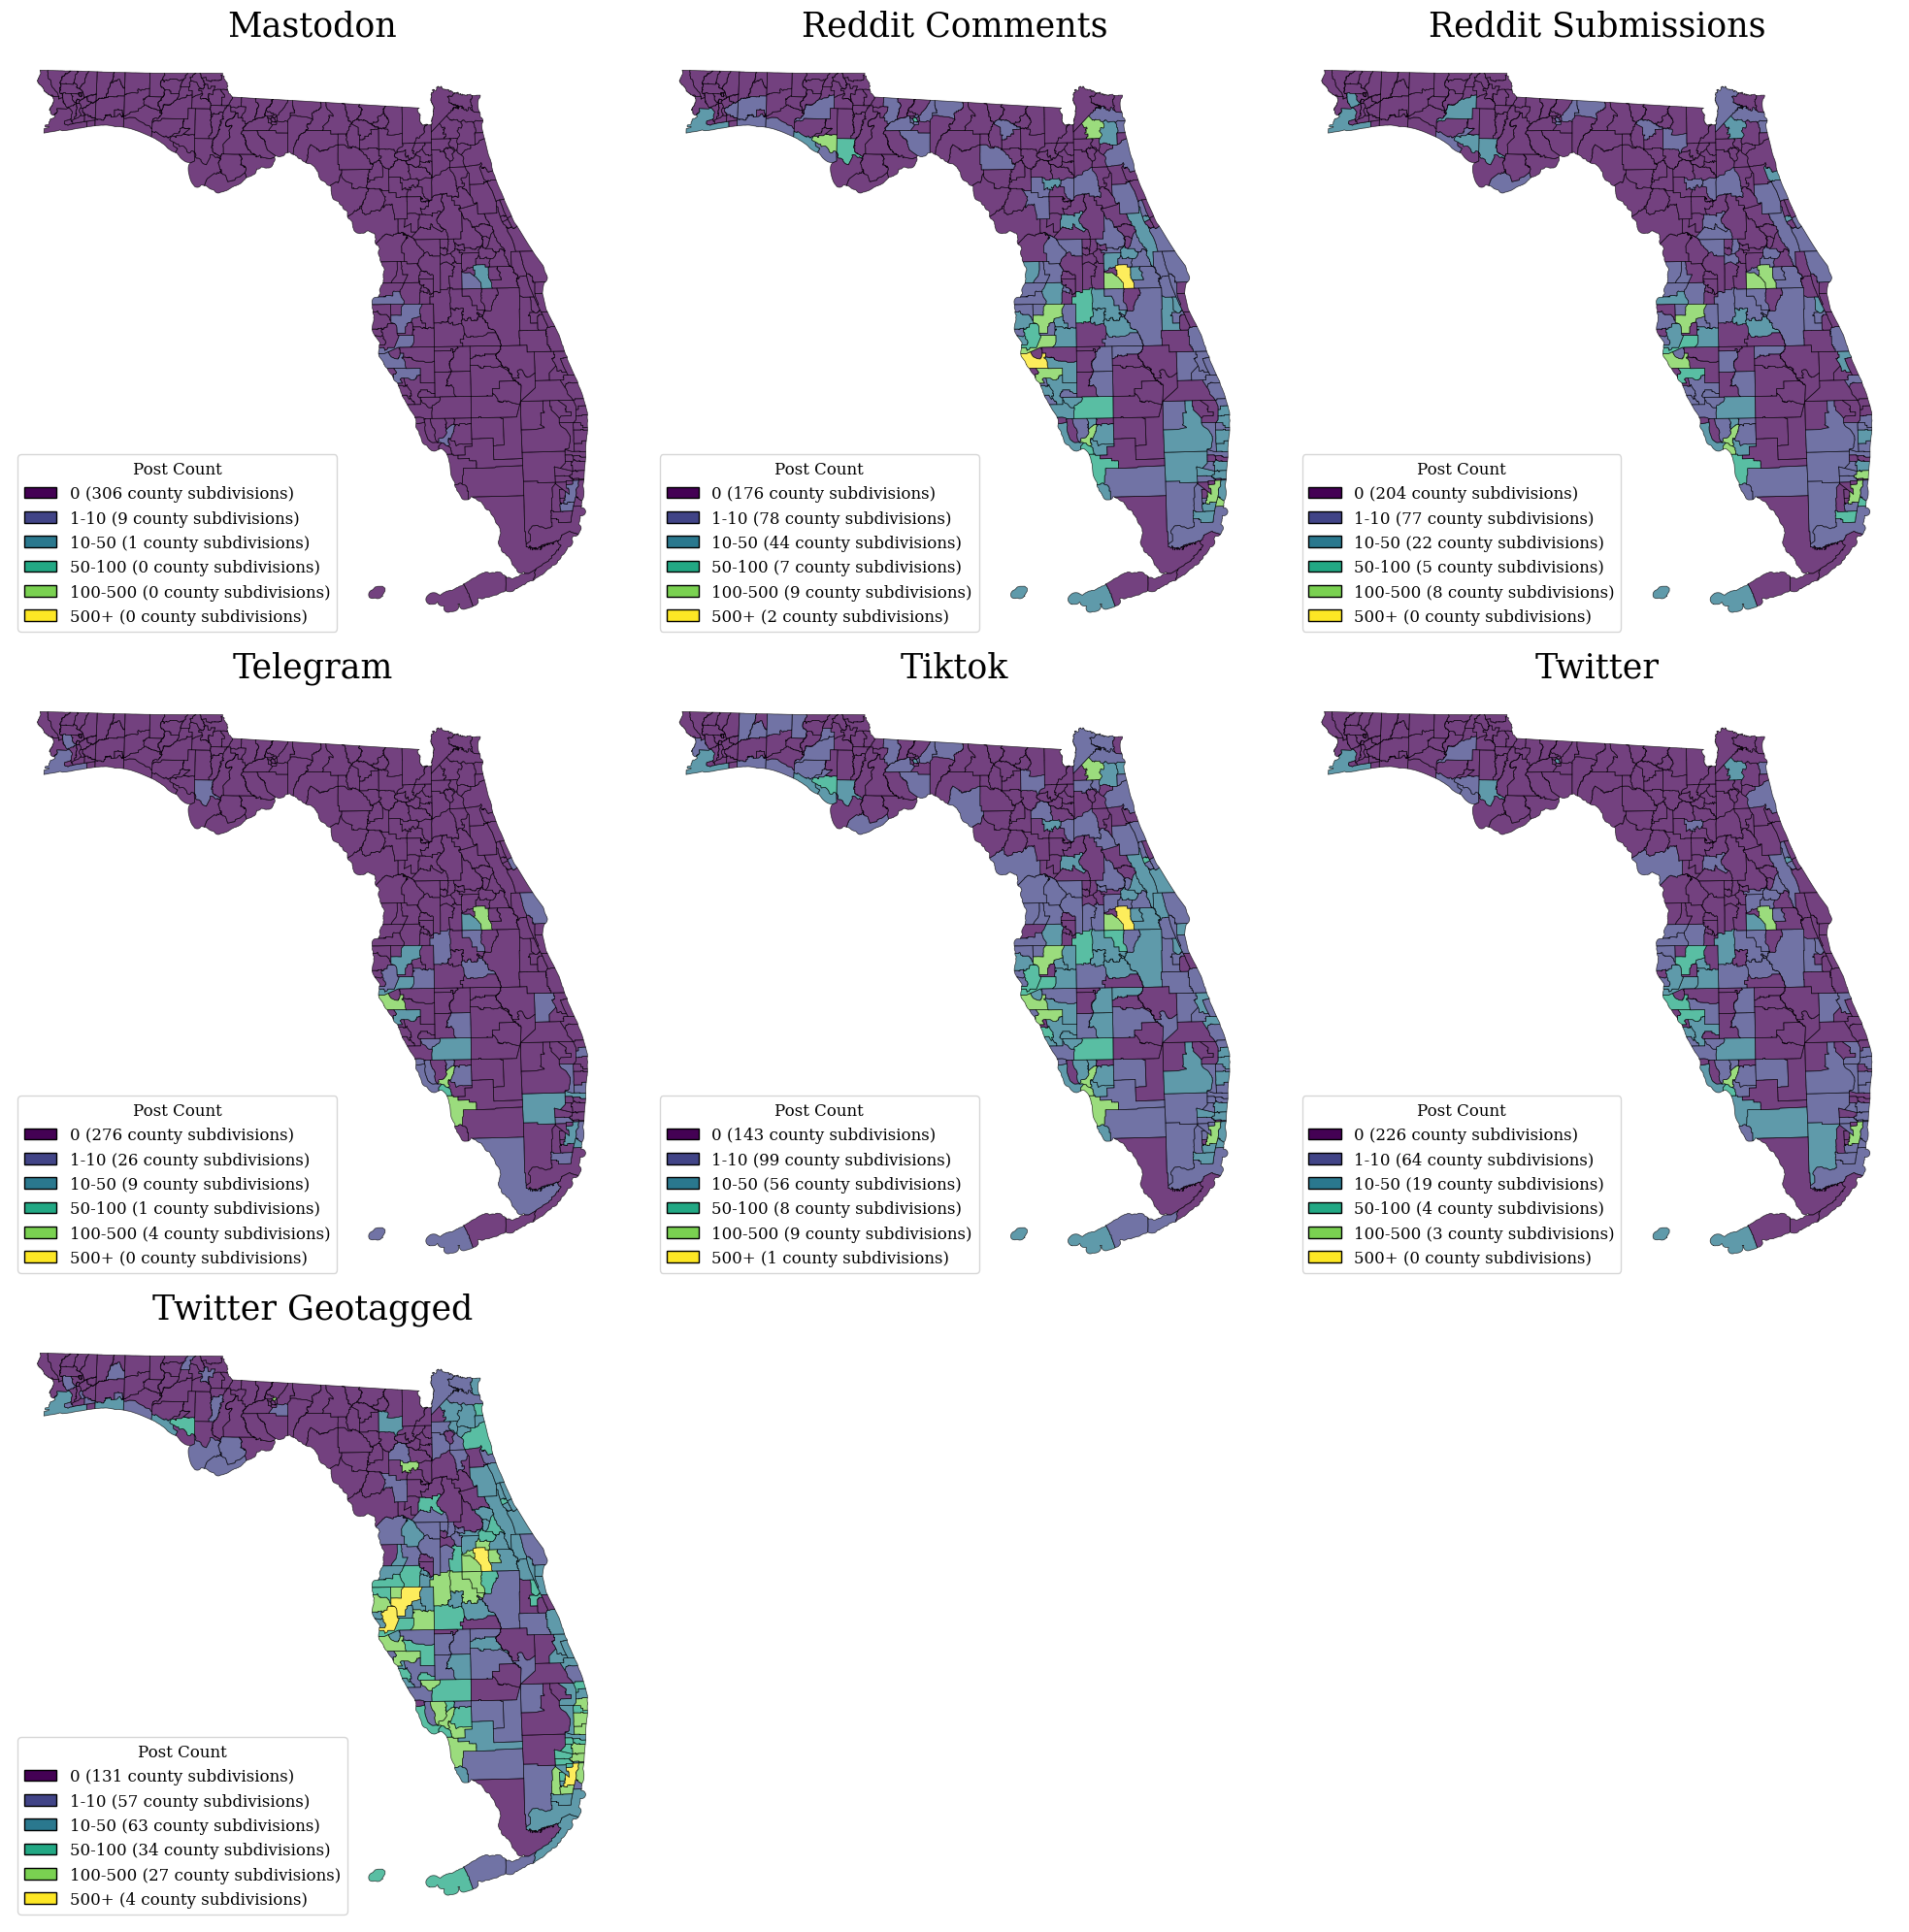

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch

# Assuming final_gdf is your GeoDataFrame
# Load point GeoDataFrame
points_gdf = gdf

# Load Florida counties GeoDataFrame
counties_gdf = gpd.read_file('dataset/county_subdivisions.gpkg')
proj_crs = 'EPSG:3086'
counties_gdf = counties_gdf.to_crs(proj_crs)

# Get unique values in the "source" column
unique_sources = points_gdf['source'].unique()

# List to store GeoDataFrames for each source
source_gdfs = []

# Iterate over each unique source
for source in unique_sources:
    # Filter points for the current source
    points_subset = points_gdf[points_gdf['source'] == source]
    
    # Perform spatial join between points and counties for the current source
    points_in_counties = gpd.sjoin(counties_gdf, points_subset, how='inner', op='contains')
    
    # Calculate number of points in each county for the current source
    point_counts = points_in_counties.groupby('NAME').size().reset_index(name='point_count')
    
    # Merge point counts with counties GeoDataFrame
    source_county_gdf = pd.merge(counties_gdf, point_counts, on='NAME', how='left')
    
    # Fill missing values with 0 (for counties with no points for the current source)
    source_county_gdf['point_count'].fillna(0, inplace=True)
    
    # Add "source" column from points_gdf
    source_county_gdf['source'] = source
    
    # Append GeoDataFrame for the current source to the list
    source_gdfs.append(source_county_gdf)

# Concatenate GeoDataFrames for all sources
final_gdf = pd.concat(source_gdfs, ignore_index=True)

# Define custom bin edges and labels
bin_edges = [0, 1, 10, 50, 100, 500, np.inf]
bin_labels = ['0', '1-10', '10-50', '50-100', '100-500', '500+']

# Number of sources
num_sources = len(unique_sources)

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
# Set the font family
plt.rcParams['font.family'] = 'sans-serif'

# Specify the font to use for sans-serif
# plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'sans-serif']
# Iterate over each source and corresponding axis
for ax, (source, data) in zip(axes, final_gdf.groupby("source")):
    # Bin the data manually
    data["binned"] = pd.cut(data["point_count"], bins=bin_edges, labels=bin_labels, include_lowest=True)
    
    # Plot the data
    data.plot(
        column="binned",
        cmap="viridis",
        edgecolor="black",
        linewidth=0.5,
        alpha=0.75,
        legend=False,
        ax=ax,
    )
    
    # Remove axis for clean plot
    ax.set_axis_off()
    
    # Create custom legend
    norm = Normalize(vmin=0, vmax=len(bin_labels) - 1)
    sm = ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    # Calculate the count of counties falling within each bin
    county_counts = data.groupby("binned").size()
    # print(county_counts)

    # Create custom legend with county counts
    legend_elements_with_counts = [
        Patch(facecolor=sm.to_rgba(i), edgecolor='black', label=f"{label} ({county_counts.get(label, 0)} county subdivisions)")
        for i, label in enumerate(bin_labels)
    ]

    # Update legend with county counts{int(data["point_count"].max())}
    ax.legend(handles=legend_elements_with_counts, title=f"Post Count", loc='lower left', frameon=True, fontsize='large',  title_fontsize='large')
    
    # Add title to the plot
    ax.set_title(f"{source}", fontsize=25)
    

# Hide any remaining empty subplots
for i in range(num_sources, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445:

                    Mastodon  Reddit Comments  Reddit Submissions   Twitter  \
Mastodon            1.000000         0.869708            0.823170  0.898199   
Reddit Comments     0.869708         1.000000            0.866756  0.932332   
Reddit Submissions  0.823170         0.866756            1.000000  0.867077   
Twitter             0.898199         0.932332            0.867077  1.000000   
Tiktok              0.917779         0.875583            0.774026  0.936874   
Telegram            0.805757         0.851058            0.882781  0.852333   
Twitter Geotagged   0.785097         0.793235            0.740130  0.844237   

                      Tiktok  Telegram  Twitter Geotagged  
Mastodon            0.917779  0.805757           0.785097  
Reddit Comments     0.875583  0.851058           0.793235  
Reddit Submissions  0.774026  0.882781           0.740130  
Twitter             0.936874  0.852333           0.844237  
Tiktok              1.000000  0.811874           0.756135  
Telegra

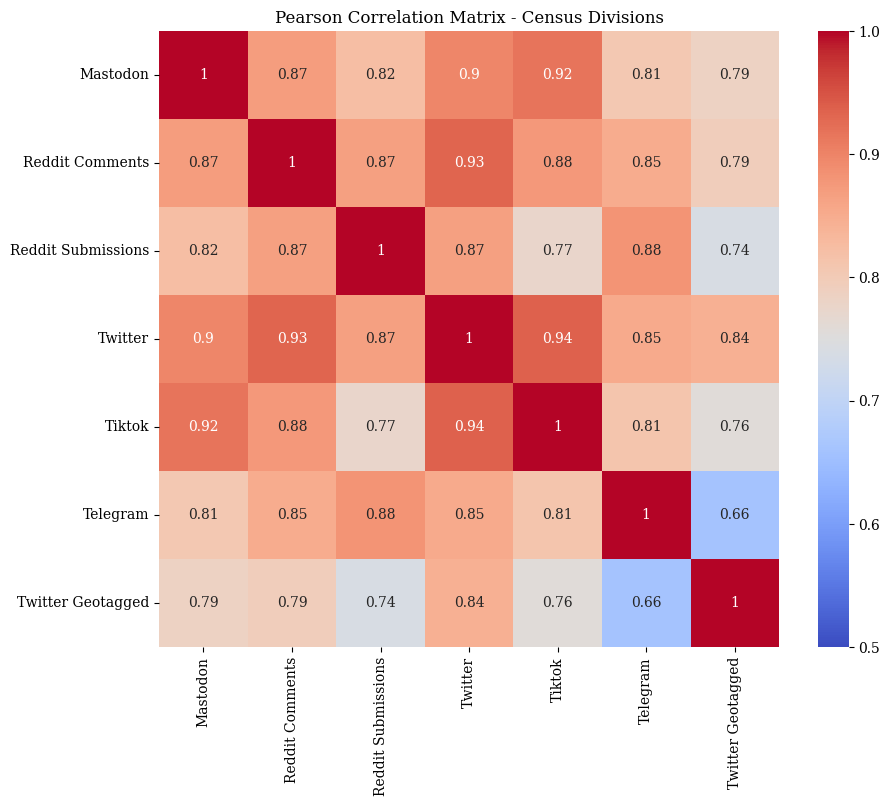

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load point GeoDataFrame
points_gdf = gdf

# Load Florida counties GeoDataFrame
counties_gdf = gpd.read_file('dataset/county_subdivisions.gpkg')
proj_crs = 'EPSG:3086'
counties_gdf = counties_gdf.to_crs(proj_crs)

# Get unique values in the "source" column
unique_sources = points_gdf['source'].unique()

# List to store point counts for each source
source_dfs = []

# Iterate over each unique source
for source in unique_sources:
    # Filter points for the current source
    points_subset = points_gdf[points_gdf['source'] == source]
    
    # Perform spatial join between points and counties for the current source
    points_in_counties = gpd.sjoin(counties_gdf, points_subset, how='inner', op='contains')
    
    # Calculate number of points in each county for the current source
    point_counts = points_in_counties.groupby('NAME').size().reset_index(name=source)
    
    # Merge point counts with counties GeoDataFrame
    source_dfs.append(point_counts)



# Combine all sources into a single DataFrame
combined_df = source_dfs[0]
for df in source_dfs[1:]:
    combined_df = combined_df.merge(df, on='NAME', how='outer')

# Fill missing values with 0 (for counties with no points for a given source)
combined_df.fillna(0, inplace=True)

# Compute Pearson correlation coefficient matrix, excluding the 'NAME' column
correlation_matrix = combined_df.drop(columns=['NAME']).corr(method='pearson')

print(correlation_matrix)

# Compute and print Pearson's r for each pair of sources
for i, source1 in enumerate(unique_sources):
    for j, source2 in enumerate(unique_sources):
        if i < j:
            r, p_value = pearsonr(combined_df[source1], combined_df[source2])
            print(f"Pearson's r between {source1} and {source2}: {r:.4f}, p-value: {p_value:.4e}")

# Optional: visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0.5, vmax=1)
plt.title("Pearson Correlation Matrix - Census Divisions")
plt.show()


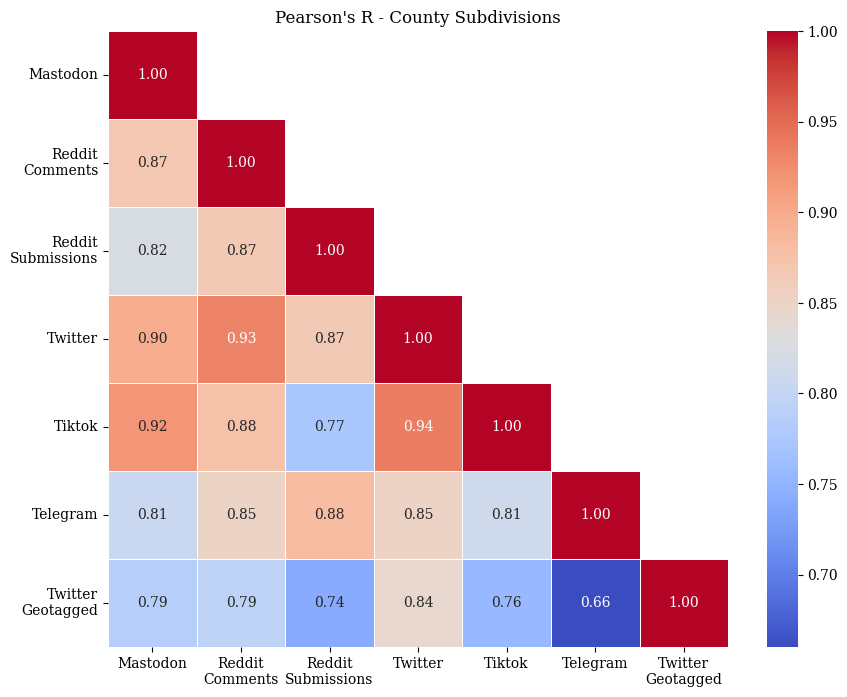

In [ ]:
correlation_matrix.index = correlation_matrix.index.str.replace(' ', '\n')
correlation_matrix.columns = correlation_matrix.columns.str.replace(' ', '\n')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  )
plt.title("Pearson's R - County Subdivisions")
plt.xlabel('')
plt.ylabel('')
plt.yticks(rotation = 0)
plt.show()

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445:

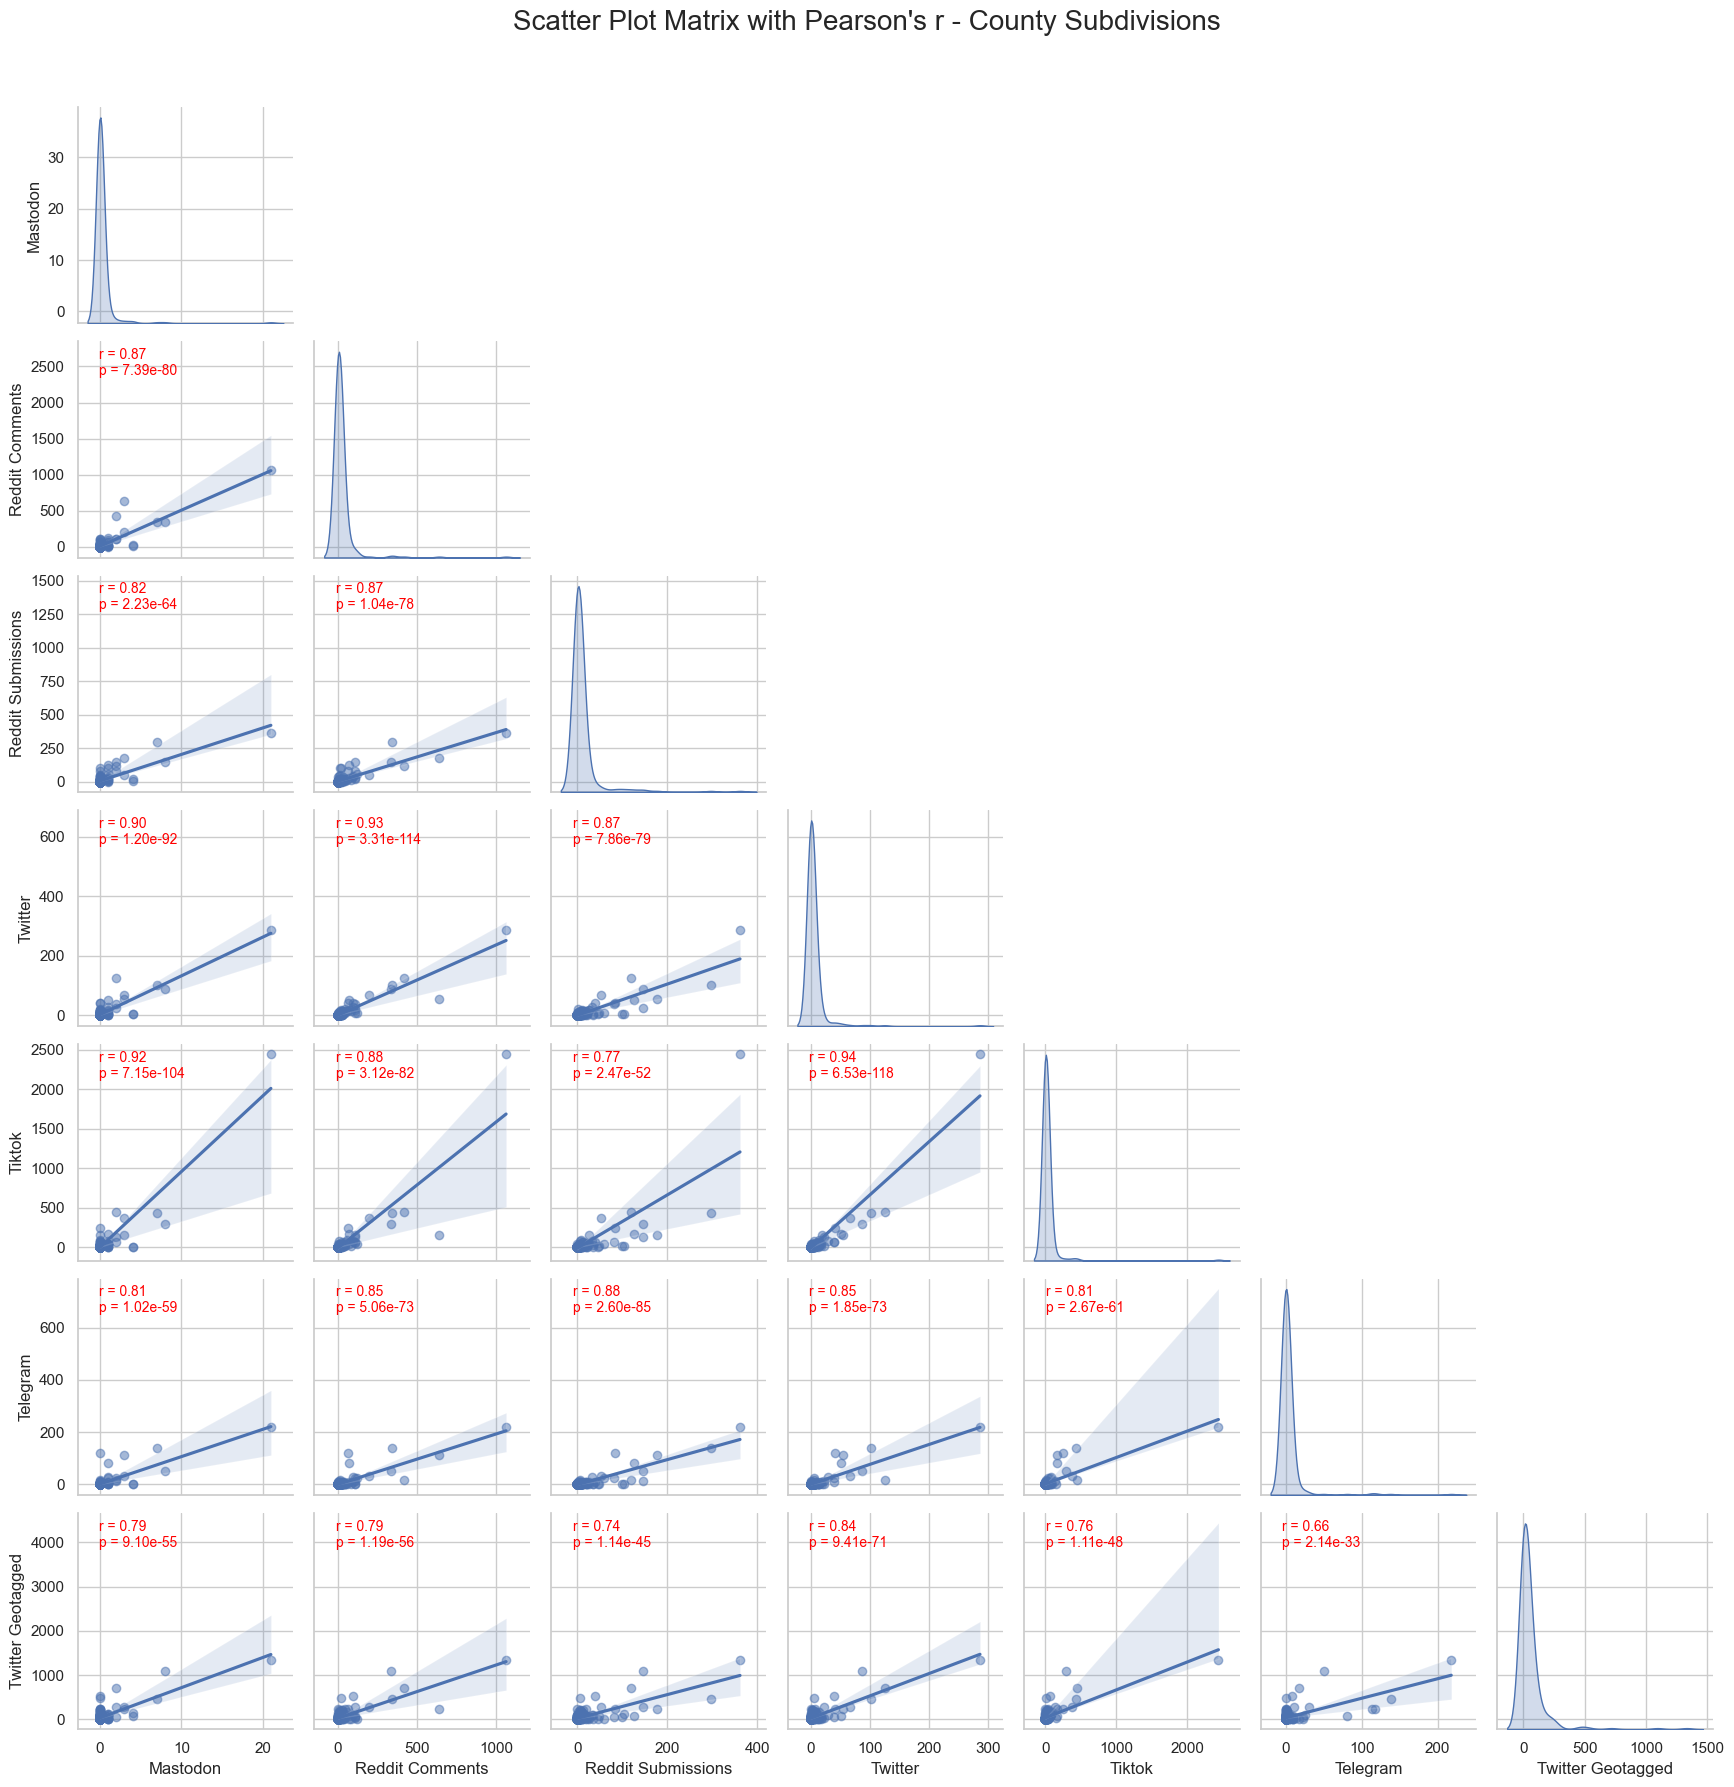

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
import geopandas as gpd

# Load point GeoDataFrame (replace this with your actual data loading code)
points_gdf = gdf

# Load Florida counties GeoDataFrame
counties_gdf = gpd.read_file('dataset/county_subdivisions.gpkg')
proj_crs = 'EPSG:3086'
counties_gdf = counties_gdf.to_crs(proj_crs)


# Get unique values in the "source" column
unique_sources = points_gdf['source'].unique()

# List to store dataframes for each source
source_dfs = []

# Iterate over each unique source
for source in unique_sources:
    # Filter points for the current source
    points_subset = points_gdf[points_gdf['source'] == source]
    
    # Perform spatial join between points and counties for the current source
    points_in_counties = gpd.sjoin(counties_gdf, points_subset, how='inner', op='contains')
    
    # Calculate number of points in each county for the current source
    point_counts = points_in_counties.groupby('NAME').size().reset_index(name=source)
    
    # Merge point counts with counties GeoDataFrame
    source_dfs.append(point_counts.set_index('NAME'))

# Concatenate DataFrames for all sources
merged_df = pd.concat(source_dfs, axis=1).fillna(0)

# Calculate Pearson correlation coefficients and p-values
pearson_results = {}
for source1 in unique_sources:
    for source2 in unique_sources:
        if source1 != source2:
            r, p = pearsonr(merged_df[source1], merged_df[source2])
            pearson_results[(source1, source2)] = (r, p)

# Create pair plot with Pearson correlation coefficients annotated
g = sns.pairplot(merged_df, kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.5}}, diag_kws={'shade': True})

# Mask the lower-right triangle (reverse of previous masking)
for i in range(len(unique_sources)):
    for j in range(len(unique_sources)):
        if i < j:
            g.axes[i, j].set_visible(False)

# Add correlation coefficients and p-values to the plots
for i, source1 in enumerate(unique_sources):
    for j, source2 in enumerate(unique_sources):
        if i != j:
            ax = g.axes[i, j]
            r, p = pearson_results[(source1, source2)]
            ax.annotate(f'r = {r:.2f}\np = {p:.2e}', xy=(0.1, 0.9), xycoords='axes fraction', ha='left', va='center', fontsize=10, color='red')

# Adjust the plot title
plt.suptitle("Scatter Plot Matrix with Pearson's r - County Subdivisions", y=1.02, fontsize=20)

plt.tight_layout()
plt.show()



## EVEN LOWER

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445:

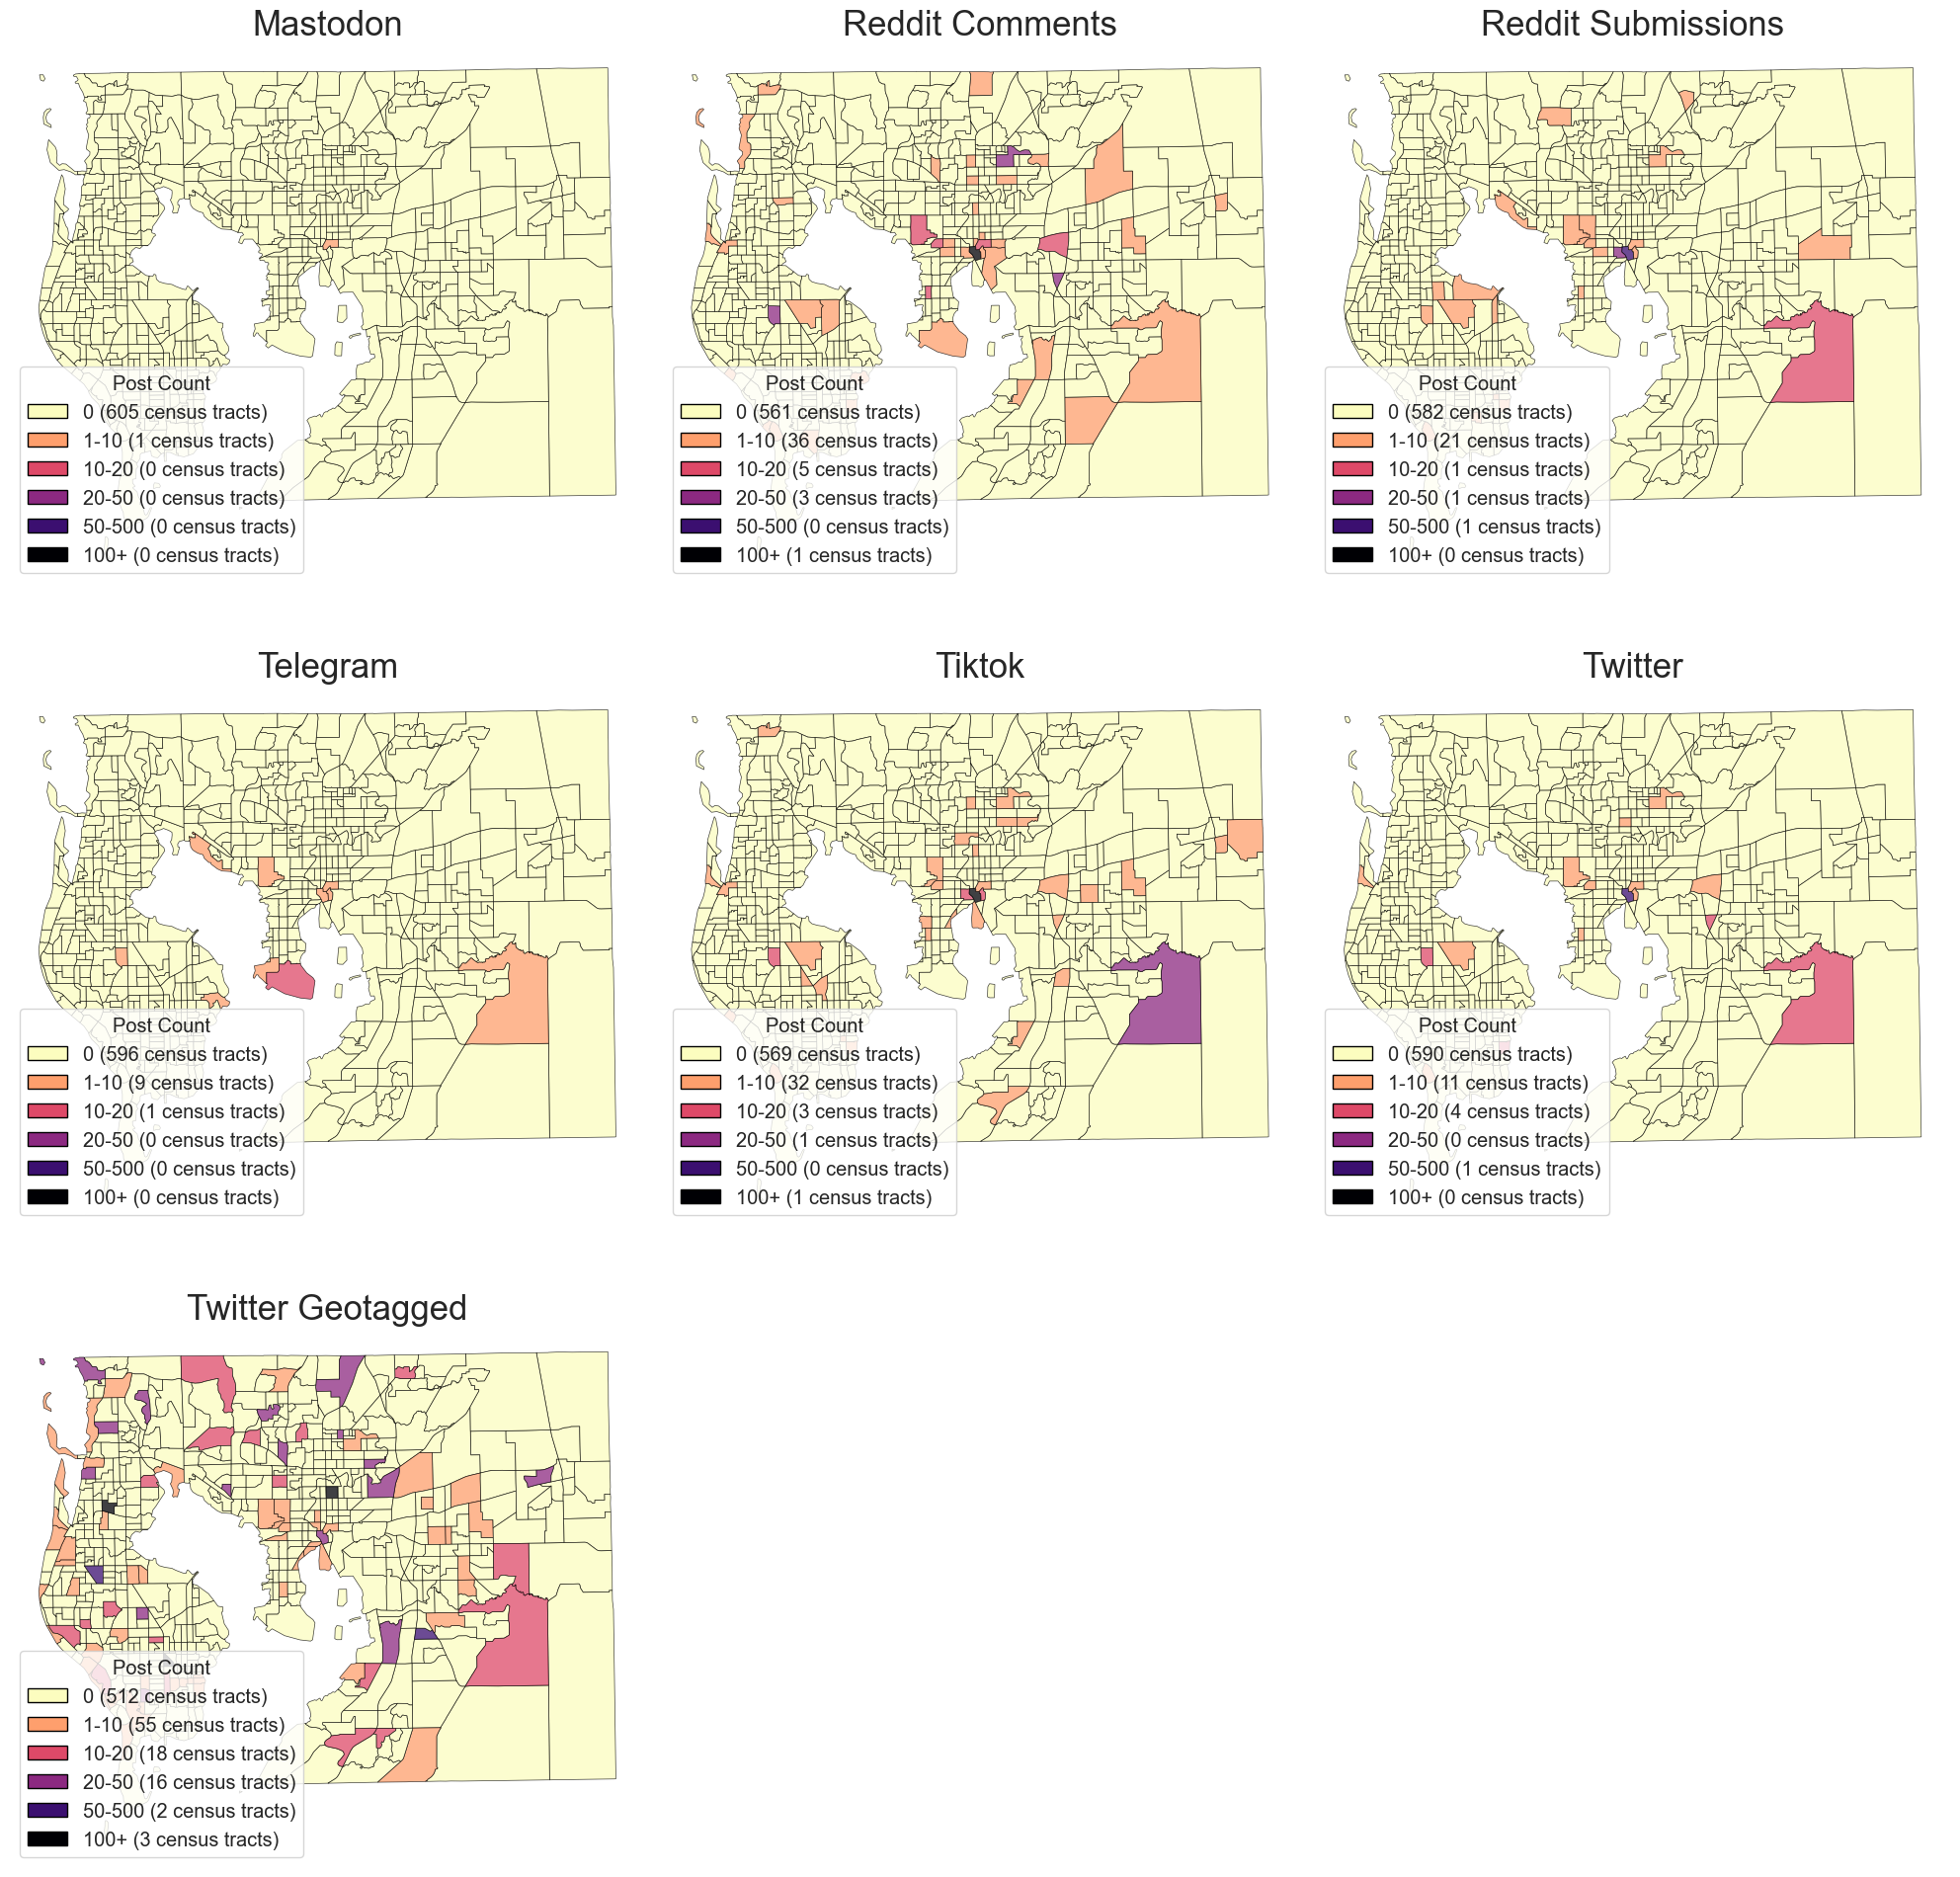

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Patch

# Assuming final_gdf is your GeoDataFrame
# Load point GeoDataFrame
points_gdf = gdf

# Load Florida counties GeoDataFrame
counties_gdf = gpd.read_file('dataset/census_tracts.gpkg')
proj_crs = 'EPSG:3086'
counties_gdf = counties_gdf.to_crs(proj_crs)

# Get unique values in the "source" column
unique_sources = points_gdf['source'].unique()

# List to store GeoDataFrames for each source
source_gdfs = []

# Iterate over each unique source
for source in unique_sources:
    # Filter points for the current source
    points_subset = points_gdf[points_gdf['source'] == source]
    
    # Perform spatial join between points and counties for the current source
    points_in_counties = gpd.sjoin(counties_gdf, points_subset, how='inner', op='contains')
    
    # Calculate number of points in each county for the current source
    point_counts = points_in_counties.groupby('FIPS').size().reset_index(name='point_count')
    
    # Merge point counts with counties GeoDataFrame
    source_county_gdf = pd.merge(counties_gdf, point_counts, on='FIPS', how='left')
    
    # Fill missing values with 0 (for counties with no points for the current source)
    source_county_gdf['point_count'].fillna(0, inplace=True)
    
    # Add "source" column from points_gdf
    source_county_gdf['source'] = source
    
    # Append GeoDataFrame for the current source to the list
    source_gdfs.append(source_county_gdf)
    # source_county_gdf.to_file(f"test/{source}.gpkg", driver="GPKG")

    

# Concatenate GeoDataFrames for all sources
final_gdf = pd.concat(source_gdfs, ignore_index=True)

# Define custom bin edges and labels
bin_edges = [0, 1, 10, 20, 50, 100, np.inf]
bin_labels = ['0', '1-10', '10-20', '20-50', '50-500', '100+']

# Number of sources
num_sources = len(unique_sources)

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.flatten()
# Set the font family
plt.rcParams['font.family'] = 'sans-serif'

# Specify the font to use for sans-serif
# plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'sans-serif']
# Iterate over each source and corresponding axis
for ax, (source, data) in zip(axes, final_gdf.groupby("source")):
    # Define the FIPS codes of the counties you want to include
    target_county_1 = 'Pinellas County'  # Example FIPS code for Miami-Dade County
    target_county_2 = 'Hillsborough County'  # Example FIPS code for Broward County

    # Filter final_gdf to include only data for the target counties
    target_county_data_1 = data[final_gdf['COUNTY'] == target_county_1]
    target_county_data_2 = data[final_gdf['COUNTY'] == target_county_2]

    # Concatenate the filtered data into a single GeoDataFrame
    data = gpd.GeoDataFrame(pd.concat([target_county_data_1, target_county_data_2], ignore_index=True))

# Now, combined_county_gdf contains data for both counties
    # Bin the data manually
    data["binned"] = pd.cut(data["point_count"], bins=bin_edges, labels=bin_labels, include_lowest=True)
    
    # Plot the data
    data.plot(
        column="binned",
        cmap="magma_r",
        edgecolor="black",
        linewidth=0.5,
        alpha=0.75,
        legend=False,
        ax=ax,
    )
    
    # Remove axis for clean plot
    ax.set_axis_off()
    
    # Create custom legend
    norm = Normalize(vmin=0, vmax=len(bin_labels) - 1)
    sm = ScalarMappable(cmap="magma_r", norm=norm)
    sm.set_array([])
    # Calculate the count of counties falling within each bin
    county_counts = data.groupby("binned").size()
    # print(county_counts)

    # Create custom legend with county counts
    legend_elements_with_counts = [
        Patch(facecolor=sm.to_rgba(i), edgecolor='black', label=f"{label} ({county_counts.get(label, 0)} census tracts)")
        for i, label in enumerate(bin_labels)
    ]

    # Update legend with county counts{int(data["point_count"].max())}
    ax.legend(handles=legend_elements_with_counts, title=f"Post Count", loc='lower left', frameon=True, fontsize='large',  title_fontsize='large')
    
    # Add title to the plot
    ax.set_title(f"{source}", fontsize=25)
    

# Hide any remaining empty subplots
for i in range(num_sources, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445:

                    Mastodon  Reddit Comments  Reddit Submissions   Twitter  \
Mastodon            1.000000         0.843503            0.781887  0.872243   
Reddit Comments     0.843503         1.000000            0.869123  0.914889   
Reddit Submissions  0.781887         0.869123            1.000000  0.841693   
Twitter             0.872243         0.914889            0.841693  1.000000   
Tiktok              0.912042         0.860774            0.761019  0.943610   
Telegram            0.783463         0.842221            0.862911  0.818717   
Twitter Geotagged   0.038457         0.035541            0.032863  0.041977   

                      Tiktok  Telegram  Twitter Geotagged  
Mastodon            0.912042  0.783463           0.038457  
Reddit Comments     0.860774  0.842221           0.035541  
Reddit Submissions  0.761019  0.862911           0.032863  
Twitter             0.943610  0.818717           0.041977  
Tiktok              1.000000  0.790163           0.041239  
Telegra

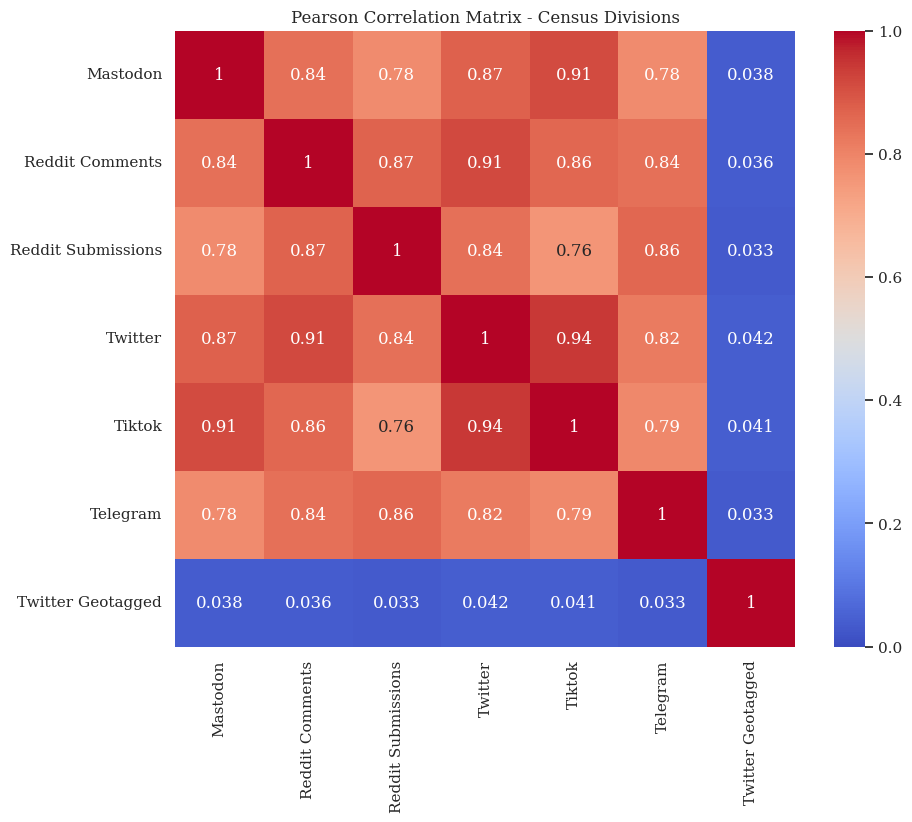

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Load point GeoDataFrame
points_gdf = gdf

# Load Florida counties GeoDataFrame
counties_gdf = gpd.read_file('dataset/census_tracts.gpkg')
proj_crs = 'EPSG:3086'
counties_gdf = counties_gdf.to_crs(proj_crs)

# Get unique values in the "source" column
unique_sources = points_gdf['source'].unique()

# List to store point counts for each source
source_dfs = []

# Iterate over each unique source
for source in unique_sources:
    # Filter points for the current source
    points_subset = points_gdf[points_gdf['source'] == source]
    
    # Perform spatial join between points and counties for the current source
    points_in_counties = gpd.sjoin(counties_gdf, points_subset, how='inner', op='contains')
    
    # Calculate number of points in each county for the current source
    point_counts = points_in_counties.groupby('FIPS').size().reset_index(name=source)
    
    # Merge point counts with counties GeoDataFrame
    source_dfs.append(point_counts)



# Combine all sources into a single DataFrame
combined_df = source_dfs[0]
for df in source_dfs[1:]:
    combined_df = combined_df.merge(df, on='FIPS', how='outer')

# Fill missing values with 0 (for counties with no points for a given source)
combined_df.fillna(0, inplace=True)

# Compute Pearson correlation coefficient matrix, excluding the 'NAME' column
correlation_matrix = combined_df.drop(columns=['FIPS']).corr(method='pearson')

print(correlation_matrix)

# Compute and print Pearson's r for each pair of sources
for i, source1 in enumerate(unique_sources):
    for j, source2 in enumerate(unique_sources):
        if i < j:
            r, p_value = pearsonr(combined_df[source1], combined_df[source2])
            print(f"Pearson's r between {source1} and {source2}: {r:.4f}, p-value: {p_value:.4e}")

# Optional: visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'sans-serif'

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Pearson Correlation Matrix - Census Divisions")
plt.grid(False)
plt.show()

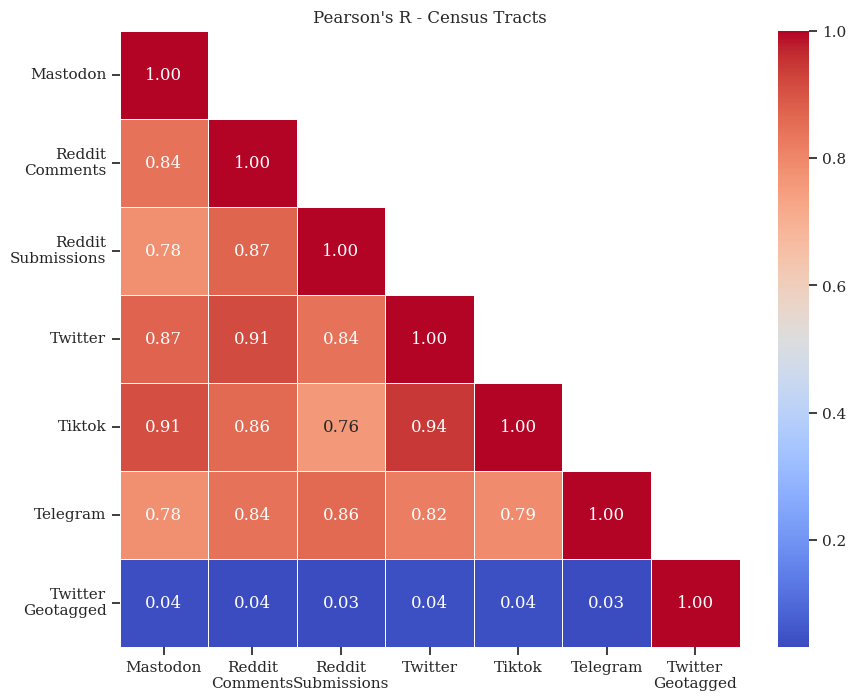

In [ ]:
correlation_matrix.index = correlation_matrix.index.str.replace(' ', '\n')
correlation_matrix.columns = correlation_matrix.columns.str.replace(' ', '\n')
sns.set_style("ticks")

# Find the path to the Computer Modern Sans Serif font file
cm_font = fm.findfont(fm.FontProperties(family='CMU Sans Serif'))

# Configure Matplotlib to use the Computer Modern Sans Serif font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DeJavu Serif']
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  )
plt.title("Pearson's R - Census Tracts")
plt.xlabel('')
plt.ylabel('')
plt.yticks(rotation = 0)
plt.xticks(rotation = 0)

plt.show()

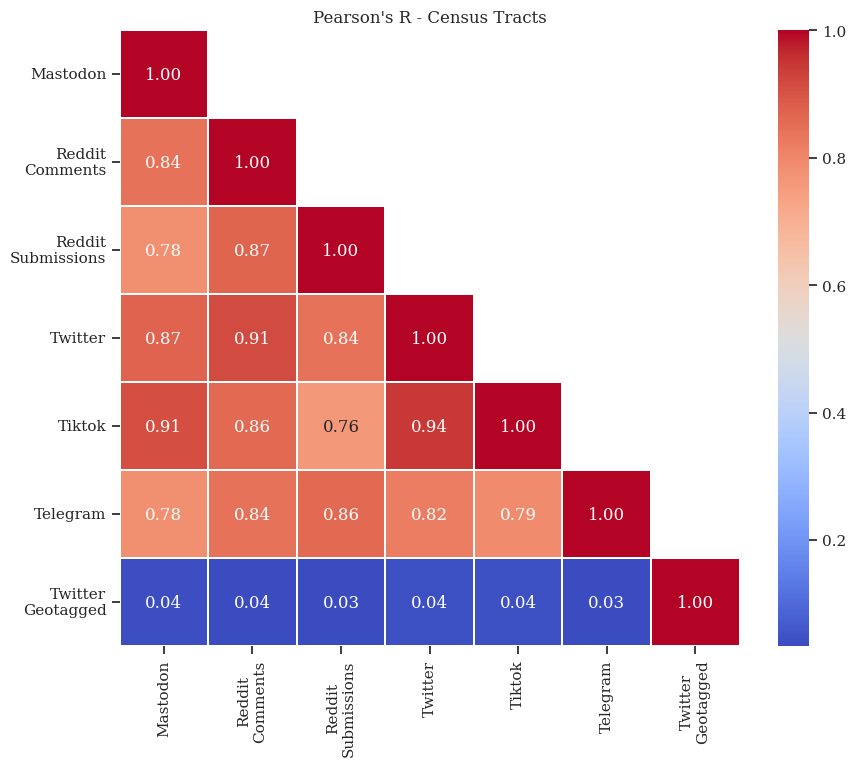

In [ ]:
correlation_matrix.index = correlation_matrix.index.str.replace(' ', '\n')
correlation_matrix.columns = correlation_matrix.columns.str.replace(' ', '\n')
sns.set_style("ticks")

# Find the path to the Computer Modern Sans Serif font file
cm_font = fm.findfont(fm.FontProperties(family='CMU Sans Serif'))

# Configure Matplotlib to use the Computer Modern Sans Serif font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DeJavu Serif']
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.1, linecolor='white', mask=np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1))
plt.title("Pearson's R - Census Tracts")
plt.xlabel('')
plt.ylabel('')
plt.yticks(rotation=0)

plt.show()

c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
c:\Users\vrace\anaconda3\envs\location-extraction311\lib\site-packages\IPython\core\interactiveshell.py:3445:

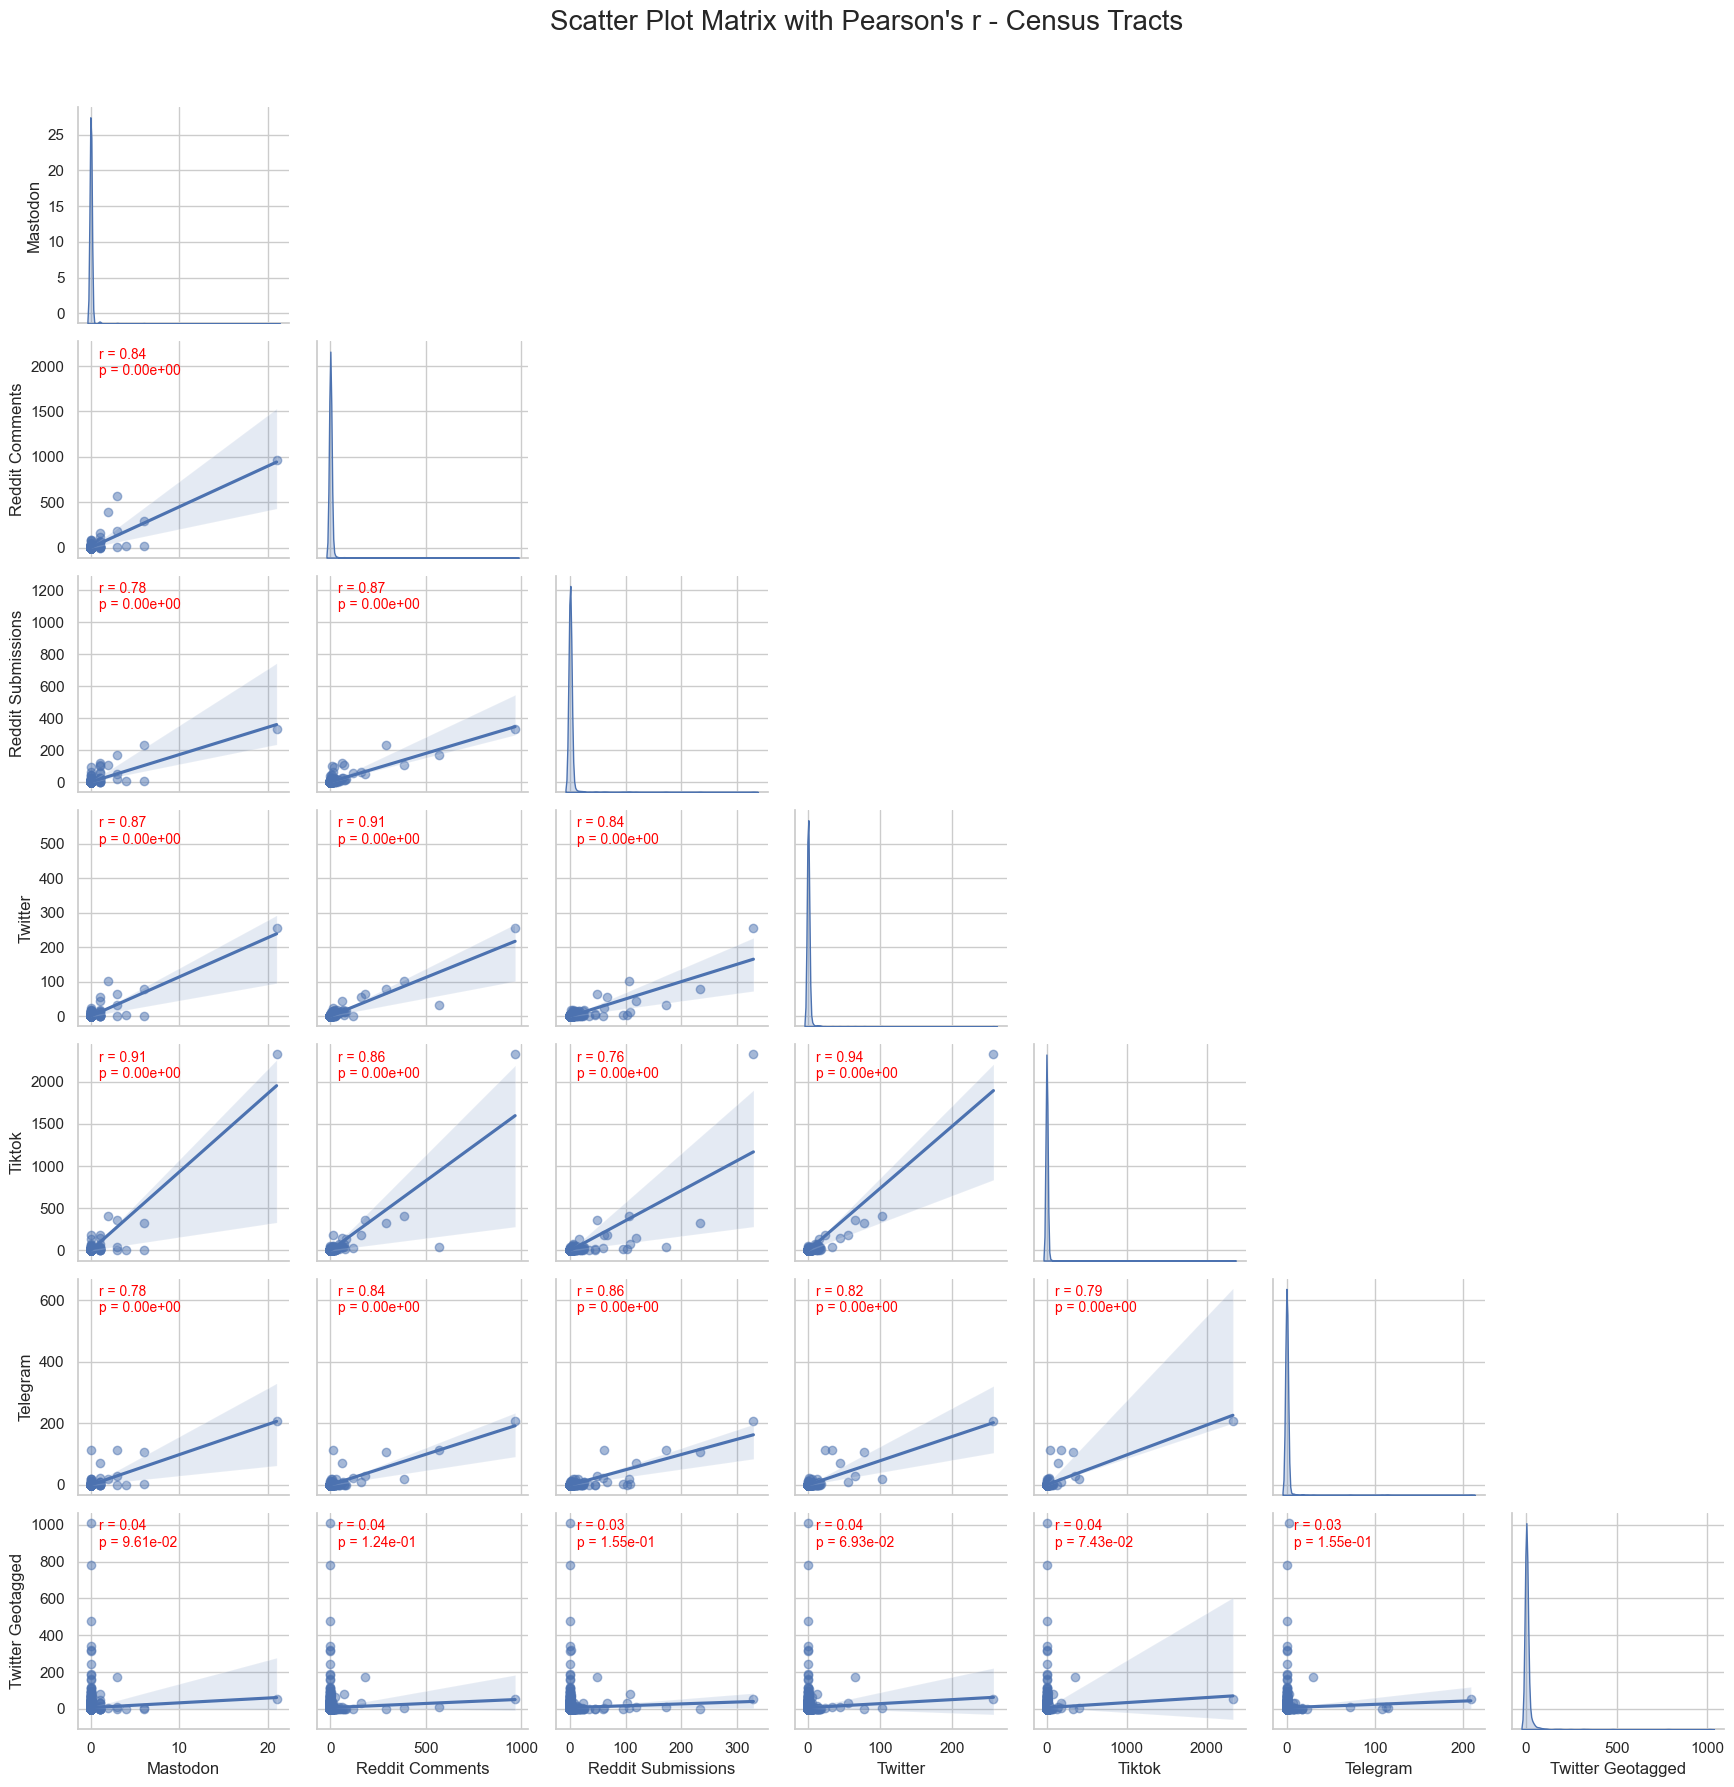

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
import geopandas as gpd

# Load point GeoDataFrame (replace this with your actual data loading code)
points_gdf = gdf

# Load Florida counties GeoDataFrame
counties_gdf = gpd.read_file('dataset/census_tracts.gpkg')
proj_crs = 'EPSG:3086'
counties_gdf = counties_gdf.to_crs(proj_crs)


# Get unique values in the "source" column
unique_sources = points_gdf['source'].unique()

# List to store dataframes for each source
source_dfs = []

# Iterate over each unique source
for source in unique_sources:
    # Filter points for the current source
    points_subset = points_gdf[points_gdf['source'] == source]
    
    # Perform spatial join between points and counties for the current source
    points_in_counties = gpd.sjoin(counties_gdf, points_subset, how='inner', op='contains')
    
    # Calculate number of points in each county for the current source
    point_counts = points_in_counties.groupby('FIPS').size().reset_index(name=source)
    
    # Merge point counts with counties GeoDataFrame
    source_dfs.append(point_counts.set_index('FIPS'))

# Concatenate DataFrames for all sources
merged_df = pd.concat(source_dfs, axis=1).fillna(0)

# Calculate Pearson correlation coefficients and p-values
pearson_results = {}
for source1 in unique_sources:
    for source2 in unique_sources:
        if source1 != source2:
            r, p = pearsonr(merged_df[source1], merged_df[source2])
            pearson_results[(source1, source2)] = (r, p)

# Create pair plot with Pearson correlation coefficients annotated
g = sns.pairplot(merged_df, kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.5}}, diag_kws={'shade': True})

# Mask the lower-right triangle (reverse of previous masking)
for i in range(len(unique_sources)):
    for j in range(len(unique_sources)):
        if i < j:
            g.axes[i, j].set_visible(False)

# Add correlation coefficients and p-values to the plots
for i, source1 in enumerate(unique_sources):
    for j, source2 in enumerate(unique_sources):
        if i != j:
            ax = g.axes[i, j]
            r, p = pearson_results[(source1, source2)]
            ax.annotate(f'r = {r:.2f}\np = {p:.2e}', xy=(0.1, 0.9), xycoords='axes fraction', ha='left', va='center', fontsize=10, color='red')

# Adjust the plot title
plt.suptitle("Scatter Plot Matrix with Pearson's r - Census Tracts", y=1.02, fontsize=20)

plt.tight_layout()
plt.show()